# 0: Import packages & data

In [49]:
install.packages('data.table')

Warning message:
"package 'data.table' is in use and will not be installed"


In [50]:
# Import packages

# Visualization packages:
library(tidyverse)
library(ggbeeswarm)
library(psych)
library(corrplot) # Correlation plot

# Data pre-processing
library(outliers)
library(EnvStats) # Rosner’s test to identify outlier

# Data manipulation: 
library(dplyr)
library(reshape2)

# Machine Learning
library(randomForest)
library(ROCR)
library(caret)
library(e1071) # Support vector machine
library(xgboost)
library(lightgbm)
library(Matrix)
library(data.table) # data table for lightgbm

# Cluster
library(cluster)
library(factoextra)

In [2]:
# Set data path
setwd("C:/Users/user/OneDrive - Erasmus University Rotterdam/Documents/01 Postgrad/02 Spring semester/06 Business Analytics for International Managers/rsm_data_analytics")

In [3]:
# Import the CSV file 
df <- read.csv("ebi_customers.csv")
head(df)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>
1,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,15592531,822,France,Male,50,7,0.00,2,1,1,10062.80,0


# 1: Data Pre-Processing

__1.1 Are there any outliers/anomaly in the data that need to be addressed?__

##### 1.1.1 Missing values

In [4]:
paste0("There are ",  sum(is.na(df)), " missing values in the dataframe.")

[1] "There are 0 missing values in the dataframe."

##### 1.1.2 Descriptive statistics

In [58]:
# Identify numerical variables
numeric_variables <- names(df)[sapply(df, function(col) {
  is.numeric(col) && length(unique(col)) > 11 && !grepl("CustomerId", col)
})]

# De-select customer_id
numeric_variables <- numeric_variables[-1]

# Print numeric variables
paste0(numeric_variables, " is a numeric variable.")

[1] "credit_score is a numeric variable."    
[2] "age is a numeric variable."             
[3] "balance is a numeric variable."         
[4] "estimated_salary is a numeric variable."

In [8]:
# to first check if we have any obvious outliers, we request standard summaries
summary(df[,numeric_variables])

  customer_id        credit_score        age           balance      
 Min.   :15565701   Min.   :350.0   Min.   :18.00   Min.   :     0  
 1st Qu.:15628656   1st Qu.:584.0   1st Qu.:32.00   1st Qu.:     0  
 Median :15690509   Median :652.0   Median :37.00   Median : 97263  
 Mean   :15691006   Mean   :650.4   Mean   :38.94   Mean   : 76650  
 3rd Qu.:15753773   3rd Qu.:717.0   3rd Qu.:44.00   3rd Qu.:127575  
 Max.   :15815690   Max.   :850.0   Max.   :92.00   Max.   :250898  
 estimated_salary   
 Min.   :    11.58  
 1st Qu.: 51446.62  
 Median :100444.88  
 Mean   :100507.32  
 3rd Qu.:149669.93  
 Max.   :199992.48  

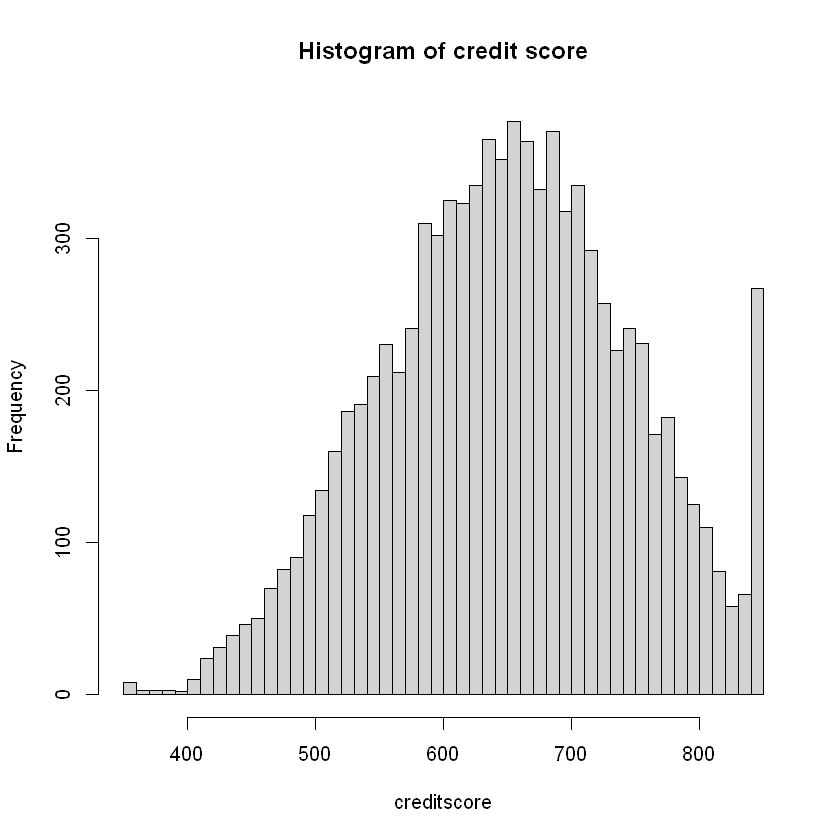

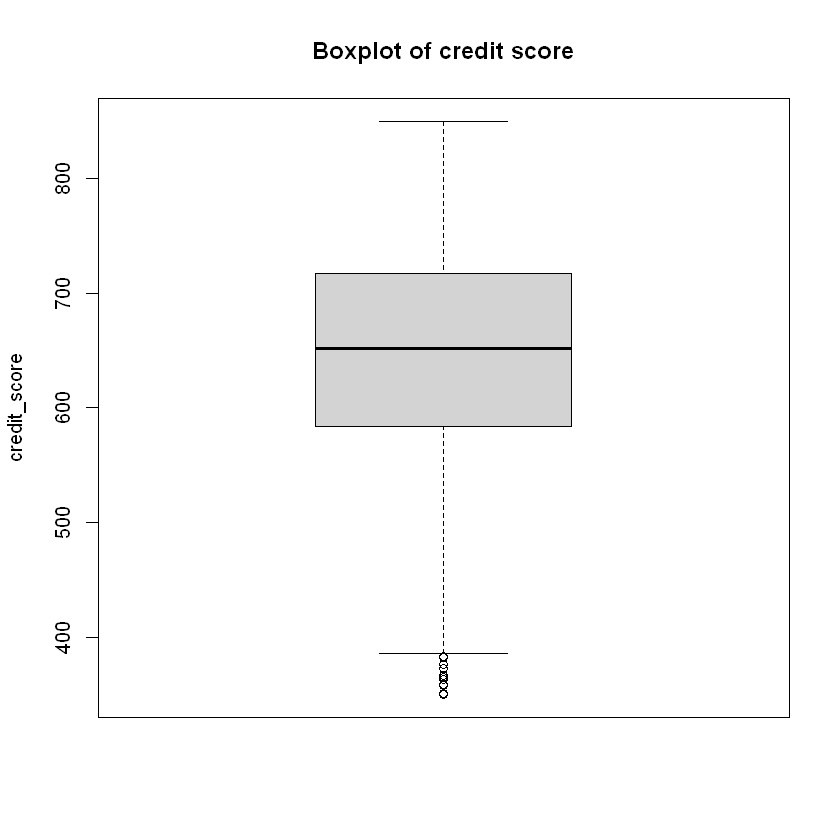

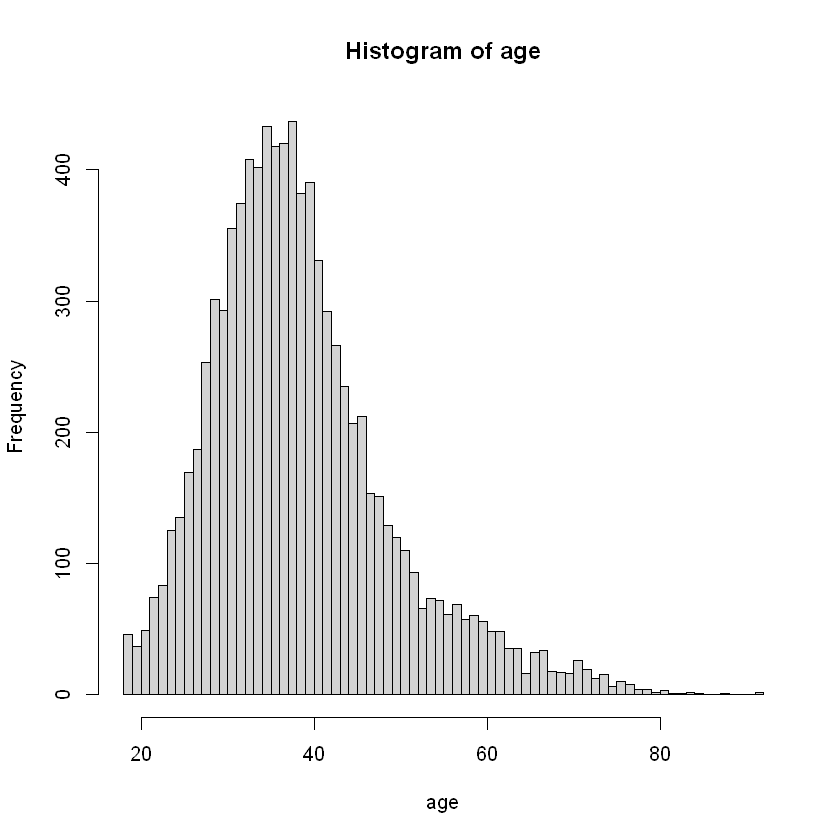

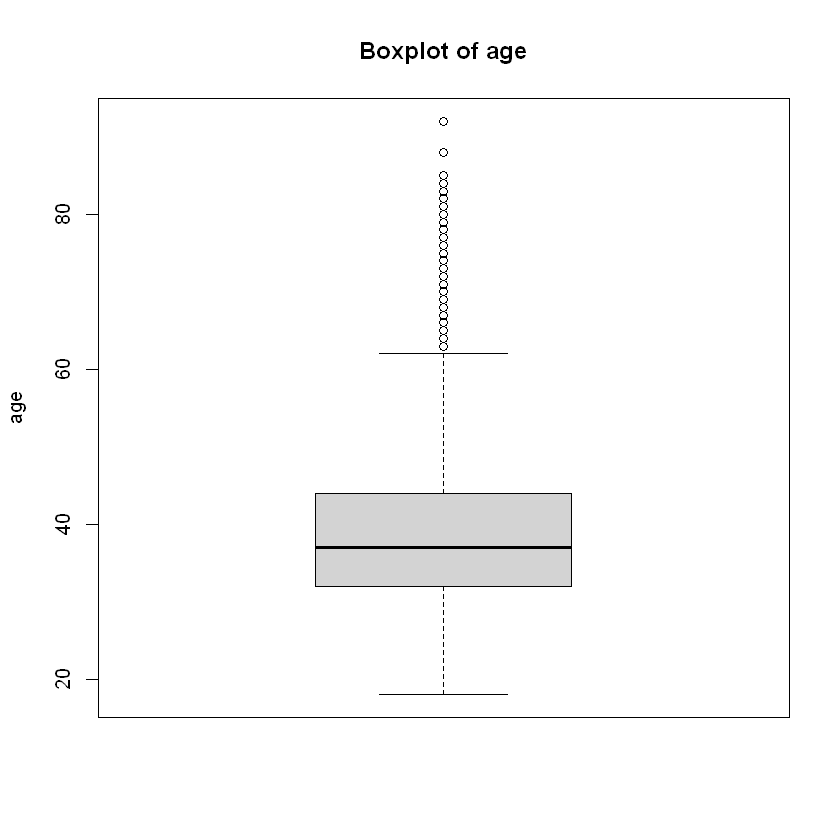

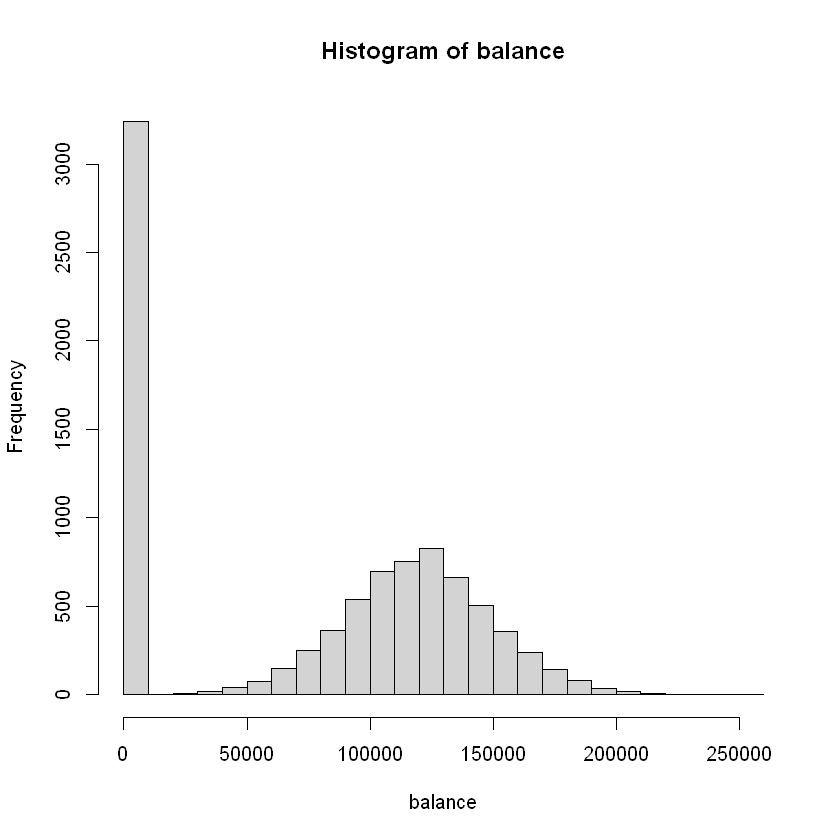

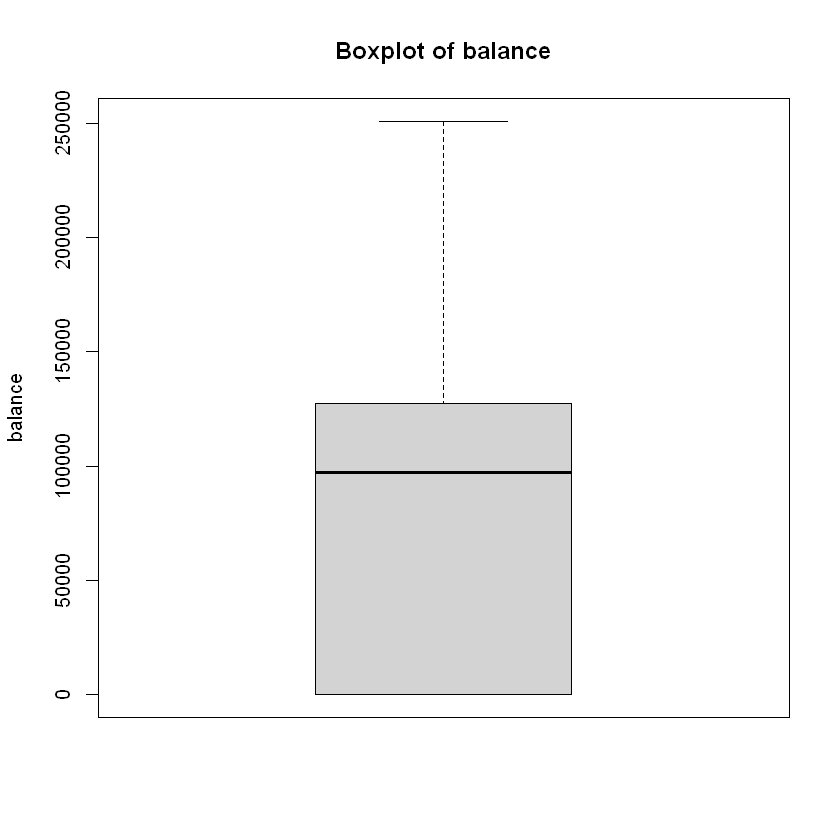

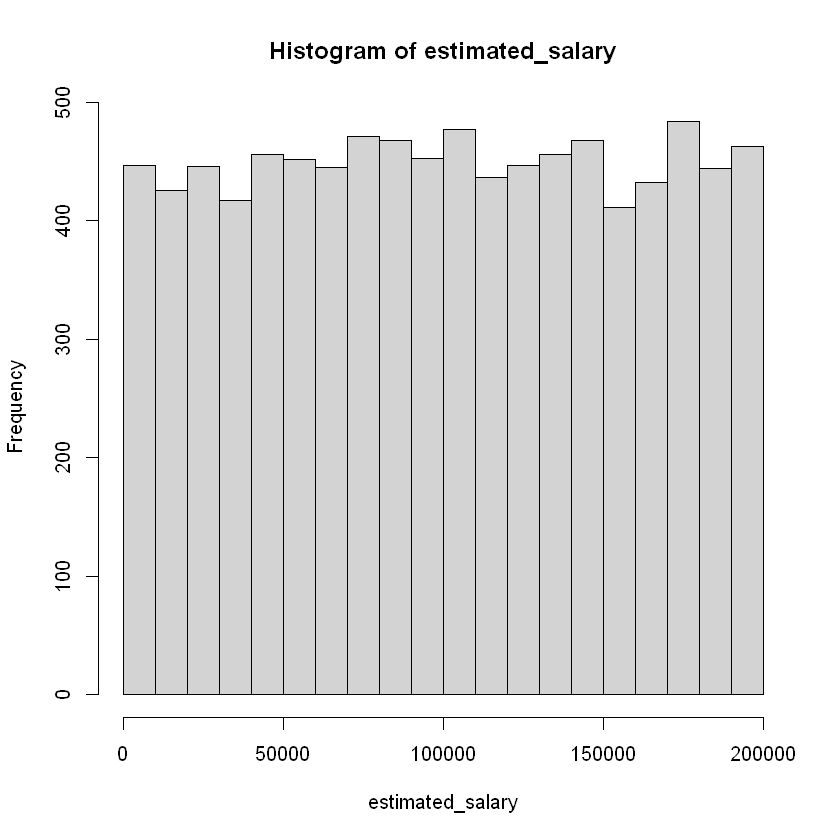

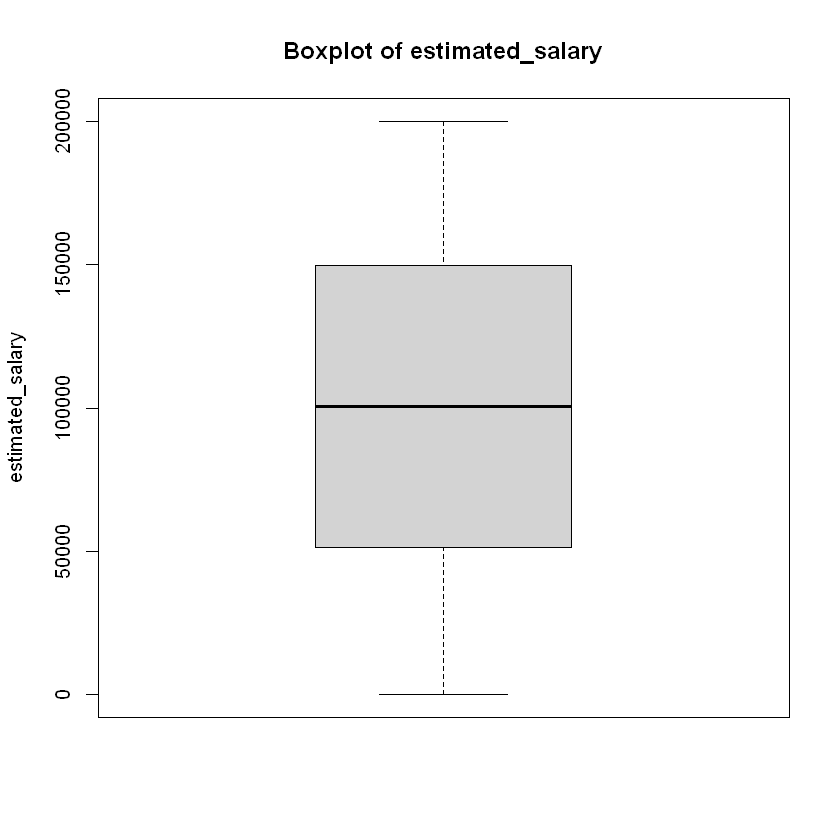

In [22]:
# we then plot histograms and boxplots to detect potential outlier and for more easy visual access
# Credit score
hist(df$credit_score,
     xlab = "creditscore",
     main = "Histogram of credit score",
     breaks = "FD")

boxplot(df$credit_score,
        ylab = "credit_score",
        main = "Boxplot of credit score")


# Age
hist(df$age,
     xlab = "age",
     main = "Histogram of age",
     breaks = "FD")

boxplot(df$age,
        ylab = "age",
        main = "Boxplot of age")


# Balance
hist(df$balance,
     xlab = "balance",
     main = "Histogram of balance",
     breaks = "FD")

boxplot(df$balance,
        ylab = "balance",
        main = "Boxplot of balance")


# Estimated salary
hist(df$estimated_salary,
     xlab = "estimated_salary",
     main = "Histogram of estimated_salary",
     breaks = "FD")

boxplot(df$estimated_salary,
        ylab = "estimated_salary",
        main = "Boxplot of estimated_salary")

In [29]:
# Count the number of credit_score and age outliers identified by the histograms
out_credit_score <- boxplot.stats(df$credit_score)$out
out_hist_credit_score <- which(df$credit_score %in% c(out_credit_score))
paste0("There are ", length(out_hist_credit_score) , " credit_score outliers identied by the boxplot")

out_age <- boxplot.stats(df$age)$out
out_hist_age <- which(df$age %in% c(out_age))
paste0("There are ", length(out_hist_age) , " age outliers identied by the boxplot")

[1] "There are 16 credit_score outliers identied by the boxplot"

[1] "There are 320 age outliers identied by the boxplot"

In [35]:
z_score_and_hample <- function(df) {
  # Z-score filter
  df$z_age <- (df$age - mean(df$age))/sd(df$age)
  df$z_creditscore <- (df$credit_score - mean(df$credit_score))/sd(df$credit_score)
  z_age_outliers <- which(df$z_age < -3 | df$z_age > 3)
  z_creditscore_outliers <- which(df$z_creditscore < -3 | df$z_creditscore > 3)
  cat(paste0(length(z_age_outliers), " outliers detected in 'age' using the z-score filter\n"))
  cat(paste0(length(z_creditscore_outliers), " outliers detected in 'credit_score' using the z-score filter\n"))
  
  # Hample filter
  lower_bound_age <- median(df$age) - 3 * mad(df$age, constant = 1)
  upper_bound_age <- median(df$age) + 3 * mad(df$age, constant = 1)
  hample_age_outliers <- which(df$age < lower_bound_age | df$age > upper_bound_age)
  lower_bound_creditscore <- median(df$credit_score) - 3 * mad(df$credit_score, constant = 1)
  upper_bound_creditscore <- median(df$credit_score) + 3 * mad(df$credit_score, constant = 1)
  hample_creditscore_outliers <- which(df$credit_score < lower_bound_creditscore | df$credit_score > upper_bound_creditscore)
  cat(paste0(length(hample_age_outliers), " outliers detected in 'age' using the Hample filter\n"))
  cat(paste0(length(hample_creditscore_outliers), " outliers detected in 'credit_score' using the Hample filter\n"))
}

In [36]:
z_score_and_hample(df)

117 outliers detected in 'age' using the z-score filter
8 outliers detected in 'credit_score' using the z-score filter
741 outliers detected in 'age' using the Hample filter
183 outliers detected in 'credit_score' using the Hample filter


In [31]:
# Define a function to perform the Shapiro-Wilk test on a variable in a dataframe
shapiro_test <- function(df, variable, n = 5000, reps = 5) {
  set.seed(123) # for reproducibility
  res <- numeric(reps) # to store test results
  for (i in 1:reps) {
    idx <- sample(nrow(df), n) # randomly select n rows
    res[i] <- shapiro.test(df[[variable]][idx])$p.value # perform Shapiro-Wilk test on selected rows
  }
  res # return vector of p-values
}

# Call the function on the df dataframe for the 'age' and 'credit_score' variables
age_p_vals <- shapiro_test(df, "age")
credit_score_p_vals <- shapiro_test(df, "credit_score")

# Print the results
cat("The p-value of the Shapiro-Wilk test for age is",  mean(age_p_vals), 
    "which indicates strong evidence against the null hypothesis that age follows a normal distribution.\n")
cat("The p-value of the Shapiro-Wilk test for credit_score is",  mean(credit_score_p_vals), 
    "which indicates strong evidence against the null hypothesis that credit_score follows a normal distribution.\n")

The p-value of the Shapiro-Wilk test for age is 1.459648e-39 which indicates strong evidence against the null hypothesis that age follows a normal distribution.
The p-value of the Shapiro-Wilk test for credit_score is 1.383542e-13 which indicates strong evidence against the null hypothesis that credit_score follows a normal distribution.


The z-score method identified 8 values as outliers, but both the Rosner test and the Grubbs test did not, it's possible that the z-score method was overly sensitive to the distribution of the data. The Shapiro test suggests that the credit_score variable is not normally distributed, which may make the z-score method less reliable.

In [13]:
# Function to perform Grubbs test on highest value of each numeric column
grubbs_test_highest <- function(df, numeric_cols) {
  out_cols <- list() # Initialize an empty list to store results
  
  # Loop through each numeric column
  for (col in numeric_cols) {
    test_res <- grubbs.test(df[[col]]) # Perform Grubbs test on column
    if (test_res$p.value < 0.05) { # Check if p-value is less than 0.05
      out_cols[[col]] <- test_res # Add result to output list
    }
  }
  
  return(out_cols) # Return output list
}

# Function to perform Grubbs test on lowest value of each numeric column
grubbs_test_lowest <- function(df, numeric_cols) {
  out_cols <- list() # Initialize an empty list to store results
  
  # Loop through each numeric column
  for (col in numeric_cols) {
    test_res <- grubbs.test(df[[col]], opposite = TRUE) # Perform Grubbs test on column with opposite direction
    if (test_res$p.value < 0.05) { # Check if p-value is less than 0.05
      out_cols[[col]] <- test_res # Add result to output list
    }
  }
  
  return(out_cols) # Return output list
}

In [14]:
grubbs_test_highest(df, numeric_variables)

$age

	Grubbs test for one outlier

data:  df[[col]]
G = 5.07579, U = 0.99714, p-value = 0.001705
alternative hypothesis: highest value 92 is an outlier



Since the p-value is less than the significance level of 0.05, we reject the null hypothesis and conclude that there is at least one outlier in the age variable. The test suggests that the highest age value 92 is an outlier.

In [15]:
grubbs_test_lowest(df, numeric_variables)

list()

In [16]:
test <- grubbs.test(df$credit_score)
test


	Grubbs test for one outlier

data:  df$credit_score
G = 3.11029, U = 0.99892, p-value = 1
alternative hypothesis: lowest value 350 is an outlier


The p-value is very high (1), indicating that there is no evidence of an outlier in the credit_score variable. Therefore, there is no reason to remove any credit_score data points based on the Grubbs test.

In [40]:
test <- rosnerTest(df$credit_score,
  k = 10
)
test$all.stats

i,Mean.i,SD.i,Value,Obs.Num,R.i+1,lambda.i+1,Outlier
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
0,650.3868,96.57842,350,1456,3.110289,4.540157,FALSE
1,650.4202,96.53186,350,1637,3.112135,4.540134,FALSE
2,650.4535,96.48524,350,7828,3.113984,4.540110,FALSE
3,650.4869,96.43859,350,7865,3.115837,4.540086,FALSE
4,650.5203,96.39189,350,8661,3.117693,4.540063,FALSE
5,650.5538,96.34514,351,2216,3.109173,4.540039,FALSE
6,650.5871,96.29870,358,1744,3.038328,4.540015,FALSE
7,650.6196,96.25461,359,1248,3.029669,4.539992,FALSE
8,650.6520,96.21081,363,1067,2.989810,4.539968,FALSE


None of the credit_score values were flagged as outliers by the Rosner test, as all the "Outlier" values are FALSE.

In [37]:
test <- rosnerTest(df$age,
  k = 10
)
test$all.stats

i,Mean.i,SD.i,Value,Obs.Num,R.i+1,lambda.i+1,Outlier
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
0,38.93500,10.45454,92,5781,5.075786,4.540157,TRUE
1,38.92910,10.44014,92,6056,5.083351,4.540134,TRUE
2,38.92321,10.42572,88,2204,4.707283,4.540110,TRUE
3,38.91775,10.41345,85,2720,4.425264,4.540086,FALSE
4,38.91263,10.40268,84,3034,4.334206,4.540063,FALSE
5,38.90762,10.39239,84,3160,4.338980,4.540039,FALSE
6,38.90260,10.38208,83,8372,4.247451,4.540015,FALSE
7,38.89770,10.37224,82,690,4.155544,4.539992,FALSE
8,38.89290,10.36285,81,4430,4.063273,4.539968,FALSE


the test suggests that at least one observation is significantly different from the others, based on a threshold set by the test

__1.2 Are there categorical variables in the dataset? 
Should you convert those variables to numerical?__

In [46]:
non_numeric_variables <- names(which(sapply(df, class) == "character"))
paste0(non_numeric_variables, " is a non-numeric variable.")

[1] "country is a non-numeric variable." "gender is a non-numeric variable."

In [10]:
#One-hot encoding of gender variable
gender_encoded <- model.matrix(~ gender - 1, data = df)
new_df <- cbind(df, gender_encoded)

#One-hot encoding of country variable
country_encoded <- model.matrix(~ country - 1, data = df)
new_df <- cbind(new_df, country_encoded)

__1.3 Are there variables in the dataset that will not be used in the analysis? Remove them.__

In [11]:
#Drop redundant one-hot encoded columns 
new_df <- select(new_df, -gender, -genderMale, -country, -countrySpain)
head(new_df)

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,genderFemale,countryFrance,countryGermany
,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,15634602,619,42,2,0.00,1,1,1,101348.88,1,1,1,0
2,15647311,608,41,1,83807.86,1,0,1,112542.58,0,1,0,0
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,1,1,0
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,1,0,0
5,15574012,645,44,8,113755.78,2,1,0,149756.71,1,0,0,0
6,15592531,822,50,7,0.00,2,1,1,10062.80,0,0,1,0


In [12]:
cor(new_df$customer_id, new_df$churn)

[1] -0.009791887

The correlation coefficient between the customer_id and the target variable churn is very low (-0.00979188662071955). This suggests that there is almost no linear relationship between the customer_id and the churn variable. The variable can therefore be removed.

In [13]:
# Drop customer_id column
new_df <- select(new_df, -customer_id)

In [14]:
head(new_df)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,genderFemale,countryFrance,countryGermany
,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,619,42,2,0.00,1,1,1,101348.88,1,1,1,0
2,608,41,1,83807.86,1,0,1,112542.58,0,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0,0
5,645,44,8,113755.78,2,1,0,149756.71,1,0,0,0
6,822,50,7,0.00,2,1,1,10062.80,0,0,1,0


# 2: Exploratory Data Analysis

__2.1: What is the overall rate of customer churn in the dataset?__

In [23]:
churn_rate <- mean(df$churn)
churn_rate_pct <-paste0(round(churn_rate*100,2),"%")
cat("The overall rate of customer churn is:",churn_rate_pct)

The overall rate of customer churn is: 20.36%

__2.2: How does the rate of customer churn vary by demographic variables such as age, gender, etc.? How does it vary across the countries?__

In [24]:
churn_rate_by_gender <- aggregate(churn ~ gender, df, function(x) round(100 * sum(x) / length(x), 2))
                                  
churn_rate_by_country <- aggregate(churn ~ country, df, function(x) round(100 * sum(x) / length(x), 2))
                                  
cat("Churn rate by gender:\n")
print(churn_rate_by_gender)
cat("\n")                         
cat("Churn rate by country:\n")
print(churn_rate_by_country)

Churn rate by gender:
  gender churn
1 Female 24.98
2   Male 16.49

Churn rate by country:
  country churn
1  France 16.15
2 Germany 32.33
3   Spain 16.70


Women have, on average, a higher churn rate then men. Germans have, on average, a higher churn rate than French and Spanish.

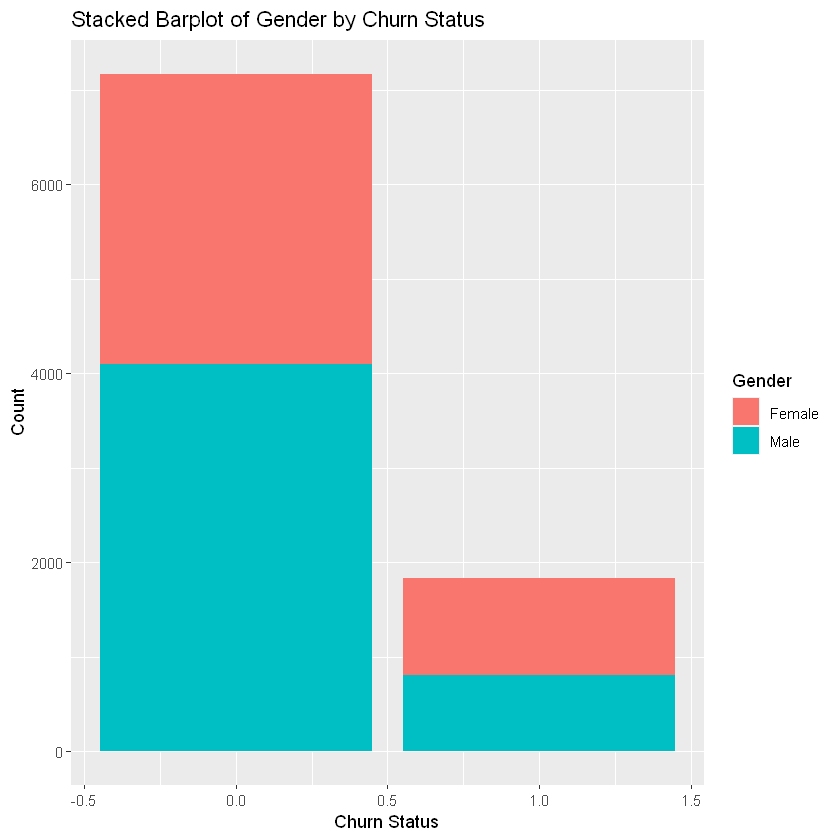

In [25]:
ggplot(data = df, aes(x = churn, fill = gender)) +
  geom_bar() +
  labs(x = "Churn Status", y = "Count", fill = "Gender") +
  ggtitle("Stacked Barplot of Gender by Churn Status")

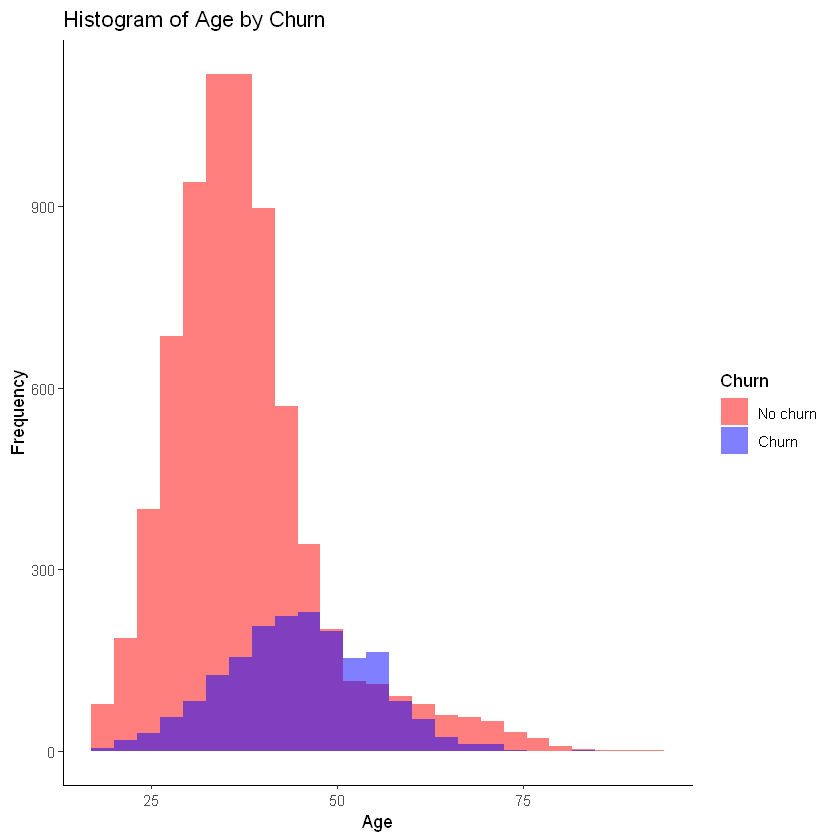

In [27]:
# Plot age distribution by churn vs. no-churn
ggplot(df, aes(x = age, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Age by Churn", x = "Age", y = "Frequency", fill = "Churn") +
  theme_classic()

In [28]:
head(df)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,z_creditscore
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,"<dbl[,1]>"
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1,-0.3249875
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,-0.4388846
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.5033549
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,2.0668511
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,-0.0557762
6,822,France,Male,50,7,0.00,2,1,1,10062.80,0,1.7769313


In [29]:
age_brackets <- cut(df$age, breaks = seq(15, 95, by = 5), right = FALSE)
churn_rate_by_age_bracket <- aggregate(churn ~ age_brackets, df, function(x) round(100 * sum(x) / length(x), 2))
cat("Churn rate by country:\n")
print(churn_rate_by_age_bracket)

Churn rate by country:
   age_brackets churn
1       [15,20)  6.52
2       [20,25)  9.24
3       [25,30)  6.89
4       [30,35)  8.46
5       [35,40) 12.97
6       [40,45) 24.17
7       [45,50) 42.84
8       [50,55) 56.28
9       [55,60) 54.55
10      [60,65) 41.44
11      [65,70) 21.37
12      [70,75) 15.91
13      [75,80)  0.00
14      [80,85) 11.11
15      [85,90)  0.00
16      [90,95)  0.00


Customers in the age group between 45 and 65 have the highest churn rate. 

In [30]:
head(df[,-12])

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7,0.00,2,1,1,10062.80,0


__2.3: Report interesting patterns that you find in the dataset.__

In [76]:
test_variables <- function(df, numeric_vars, categorical_vars, churn_var) {
  
  # create empty lists to store results
  sig_numeric_vars <- list()
  sig_categorical_vars <- list()
  
  # two-sample t-tests for numeric variables
  for (var in numeric_vars) {
    t_test <- t.test(df[[var]][df[[churn_var]] == 1], df[[var]][df[[churn_var]] == 0])
    if (t_test$p.value < 0.05) {
      sig_numeric_vars[[var]] <- t_test$p.value
      print(paste0(var, " has a statistically significant relationship with ", churn_var, ": p = ", t_test$p.value))
    }
  }
  
  # chi-squared tests for categorical variables
  for (var in categorical_vars) {
    chisq_test <- chisq.test(table(df[[var]], df[[churn_var]]))
    if (chisq_test$p.value < 0.05) {
      sig_categorical_vars[[var]] <- chisq_test$p.value
      print(paste0(var, " has a statistically significant relationship with ", churn_var, ": p = ", chisq_test$p.value))
    }
  }
  
  # return lists of significant variables
  return(list(significant_numeric_vars = sig_numeric_vars, 
              significant_categorical_vars = sig_categorical_vars))
}

In [295]:
numeric_vars <- c("credit_score", "age", "tenure", "balance", "estimated_salary")
categorical_vars <- c("gender", "credit_card", "active_member", "products_number")
statistical_test_results <- test_variables(df, numeric_vars = numeric_vars, categorical_vars = categorical_vars, "churn")

[1] "credit_score has a statistically significant relationship with churn: p = 0.00545232087507174"
[1] "age has a statistically significant relationship with churn: p = 5.25075930536332e-159"
[1] "balance has a statistically significant relationship with churn: p = 5.91301820481709e-32"
[1] "gender has a statistically significant relationship with churn: p = 3.05030632524073e-23"
[1] "active_member has a statistically significant relationship with churn: p = 1.65435283703616e-46"
[1] "products_number has a statistically significant relationship with churn: p = 5.32112719758864e-292"


For the quantitative variables, credit_score, age, and balance all have statistically significant relationships with churn. This suggests that these variables are important factors in predicting customer churn.

For the categorical variables, gender, active_member, and products_number all have statistically significant relationships with churn. This suggests that these variables are also important factors in predicting customer churn.

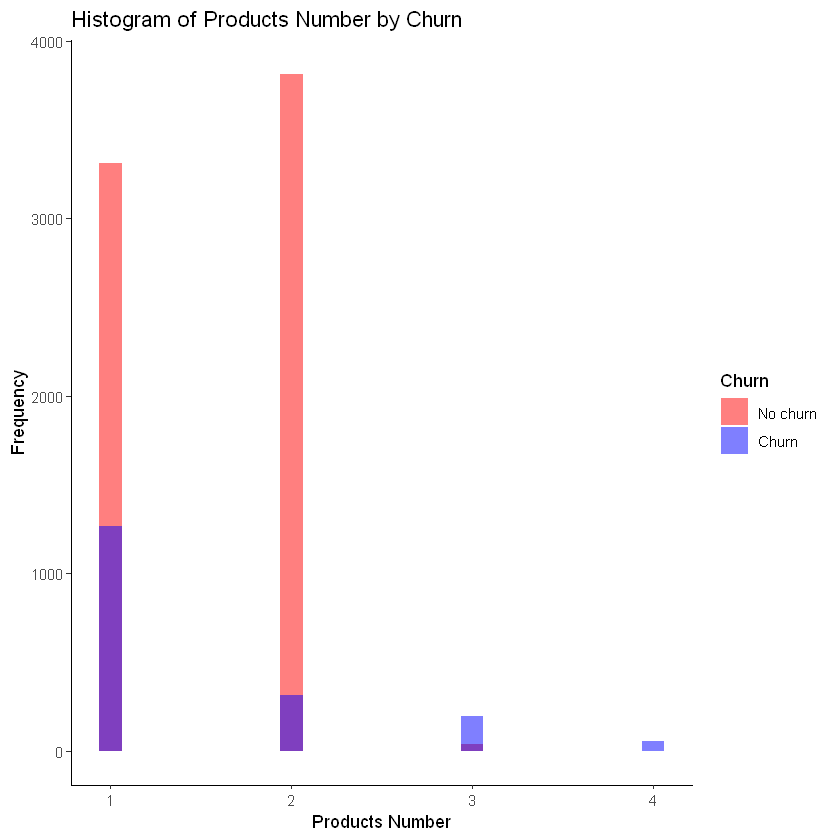

In [31]:
# Plot product number distribution by churn vs. no-churn
ggplot(df, aes(x = products_number, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Products Number by Churn", x = "Products Number", y = "Frequency", fill = "Churn") +
  theme_classic()

In [289]:
# Separate out ages for two groups
products_churn <- df$products_number[df$churn == 1]
products_no_churn <- df$products_number[df$churn == 0]

# Calculate difference in mean and median
mean_diff_products <- mean(products_no_churn) - mean(products_churn)
median_diff_products <- median(products_no_churn) - median(products_churn)
cat("Mean diff in number of products:", mean_diff_products, "\n")
cat("Median diff in number of products:", median_diff_products, "\n")

# Run t-test
ttest <- t.test(products_churn, products_no_churn)
pval <- ttest$p.value
cat("P-value for number of products vs churn:", pval, "\n")

Mean diff in number of products: 0.0712257 
Median diff in number of products: 1 
P-value for number of products vs churn: 0.0002905912 


There seems to be a statistically significant relationship between the number of products and churn. Customers that have a higher number of products are less likely to churn. The fact, however, that customers with four products have all churned goes against this observation. 

In [33]:
head(subset(df, products_number == 4))

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,z_creditscore
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,"<dbl[,1]>"
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,-2.8410774
65,738,Germany,Male,58,2,133745.44,4,1,0,28373.86,1,0.9071718
1115,628,France,Female,46,1,46870.43,4,1,0,31272.14,1,-0.2317990
1307,819,Germany,Female,49,1,120656.86,4,0,0,166164.30,1,1.7458685
1324,596,Spain,Male,30,6,121345.88,4,1,0,41921.75,1,-0.5631359
1519,792,France,Male,50,9,0.00,4,1,1,194700.81,1,1.4663029


In [34]:
# create contingency table to test relationship between churn and membership status
table_active_member <- table(df$active_member, df$churn)
rownames(table_active_member) <- c("Non-Active Member", "Active Member")
colnames(table_active_member) <- c("Not Churned", "Churned")

# run chi-squared test and print p-value
test <- chisq.test(table_active_member)
pval <- test$p.value
print(pval)

# print expected values
expected <- test$expected
rownames(expected) <- rownames(table_active_member)
colnames(expected) <- colnames(table_active_member)
print(expected)

[1] 1.654353e-46
                   
                    Not Churned  Churned
  Non-Active Member    3478.869 889.1307
  Active Member        3689.131 942.8693


There is a statistically significant relationship between membership status and churn. Non-active members are more likely to churn than active members. 

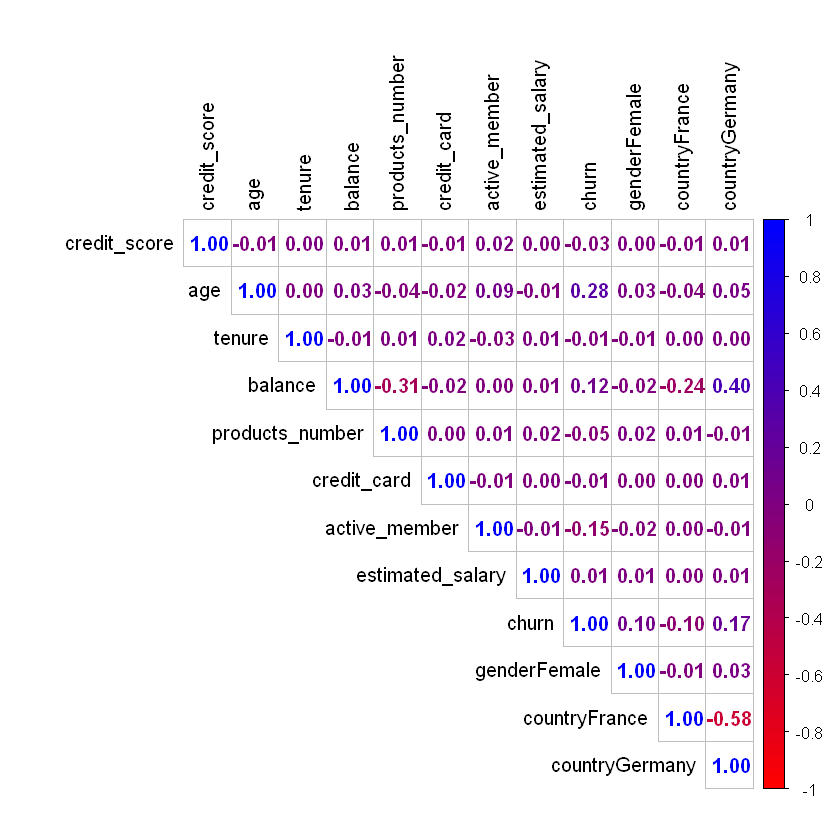

In [15]:
df_corr <- corrplot(cor(new_df), 
                          type = "upper",
                          method = "number",
                          tl.col = "black",
                          col = colorRampPalette(c("red", "blue"))(100))

__2.4: Further non-significant findings:__

Warning message:
"The following aesthetics were dropped during statistical transformation: fill
i This can happen when ggplot fails to infer the correct grouping structure in the data.
i Did you forget to specify a `group` aesthetic or to convert a numerical variable into a factor?"


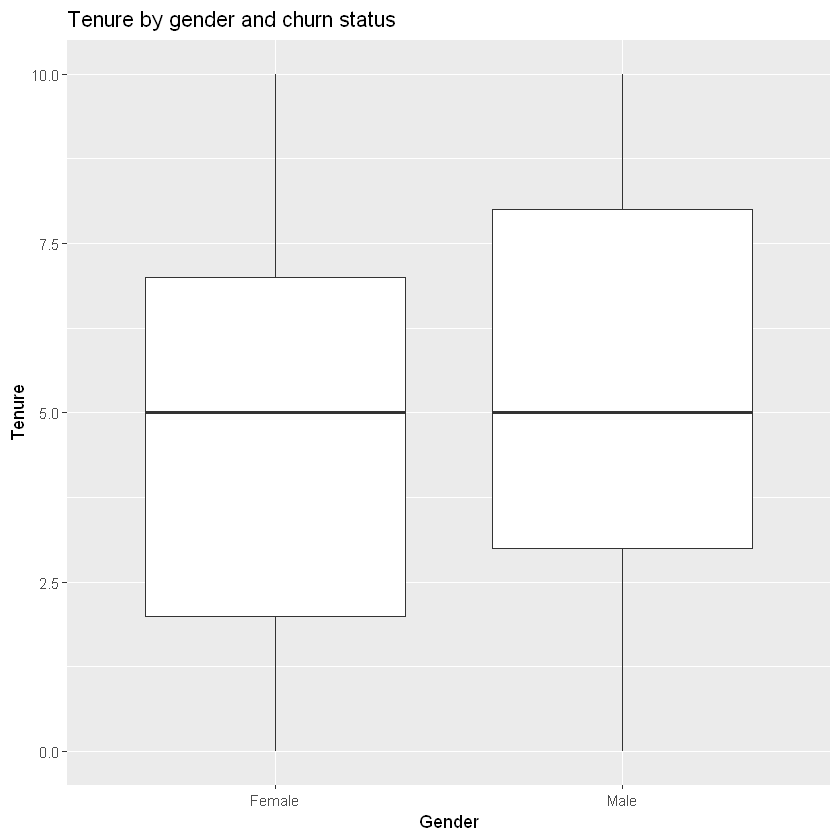

In [35]:
ggplot(data = df, aes(x = gender, y = tenure, fill = churn)) +
  geom_boxplot() +
  labs(title = "Tenure by gender and churn status", x = "Gender", y = "Tenure") +
  scale_fill_manual(values = c("#00BFC4", "#F8766D")) # optional: custom color palette

In [36]:
ggplot(data = df, aes(x = age, y = estimated_salary, color = churn)) +
  geom_point() +
  labs(title = "Age vs. estimated salary by churn status", x = "Age", y = "Estimated salary") +
  scale_color_manual(values = c("#00BFC4", "#F8766D")) # optional: custom color palette

ERROR while rich displaying an object: Error: Continuous value supplied to discrete scale

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. paste(capture.output(print(ob

In [37]:
# create contingency table to test relationship between churn and credit card ownership
table_credit_card <- table(df$credit_card, df$churn)

# run chi-squared test and print p-value
test <- chisq.test(table_credit_card)
pval <- test$p.value
print(pval)

# print expected values
expected <- test$expected
print(expected)

[1] 0.5254901
   
          0       1
  0 2114.56  540.44
  1 5053.44 1291.56


No statistically significant relationship between churn rate and credit card ownership as p-value is not leas than the significance level of 5%

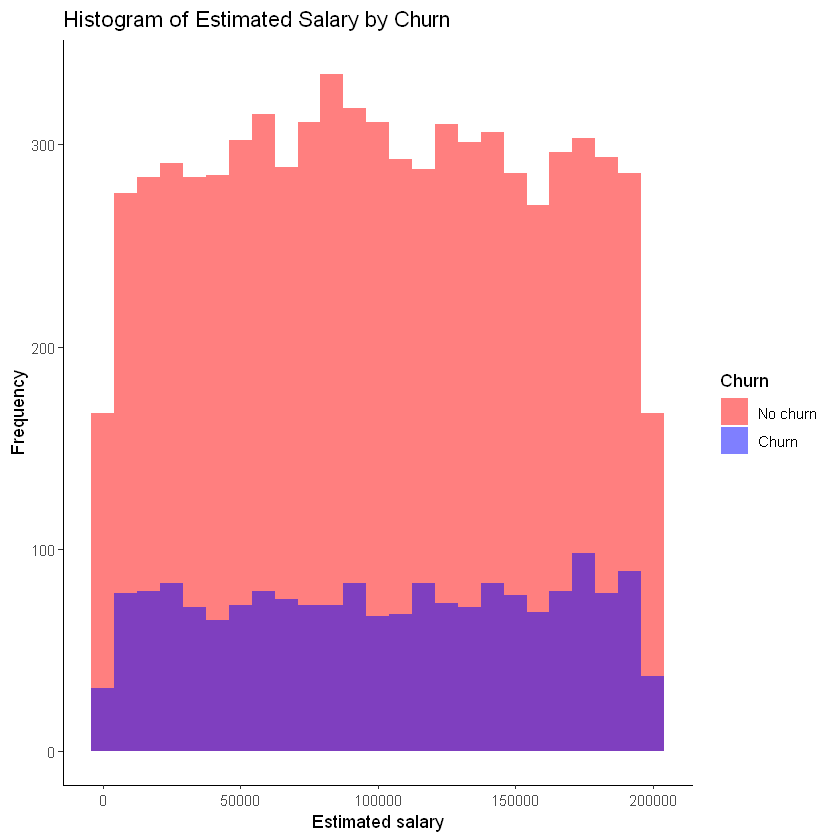

In [38]:
# Plot estimated salary distribution by churn vs. no-churn
ggplot(df, aes(x = estimated_salary, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Estimated Salary by Churn", x = "Estimated salary", y = "Frequency", fill = "Churn") +
  theme_classic()

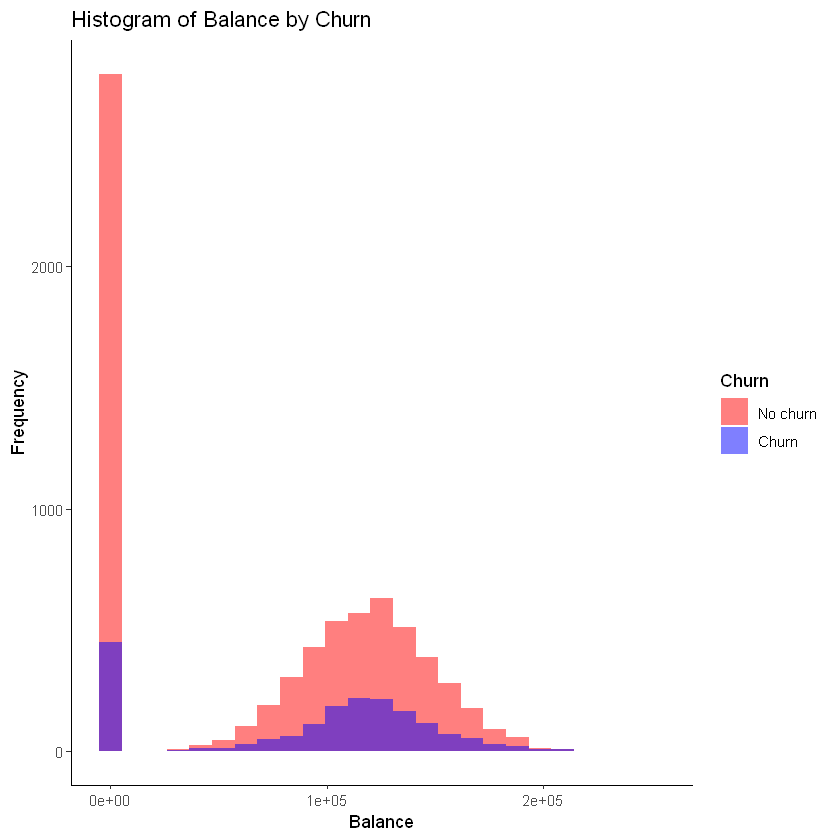

In [39]:
# Plot balance distribution by churn vs. no-churn
ggplot(df, aes(x = balance, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Balance by Churn", x = "Balance", y = "Frequency", fill = "Churn") +
  theme_classic()

Warning message:
"Continuous x aesthetic
i did you forget `aes(group = ...)`?"


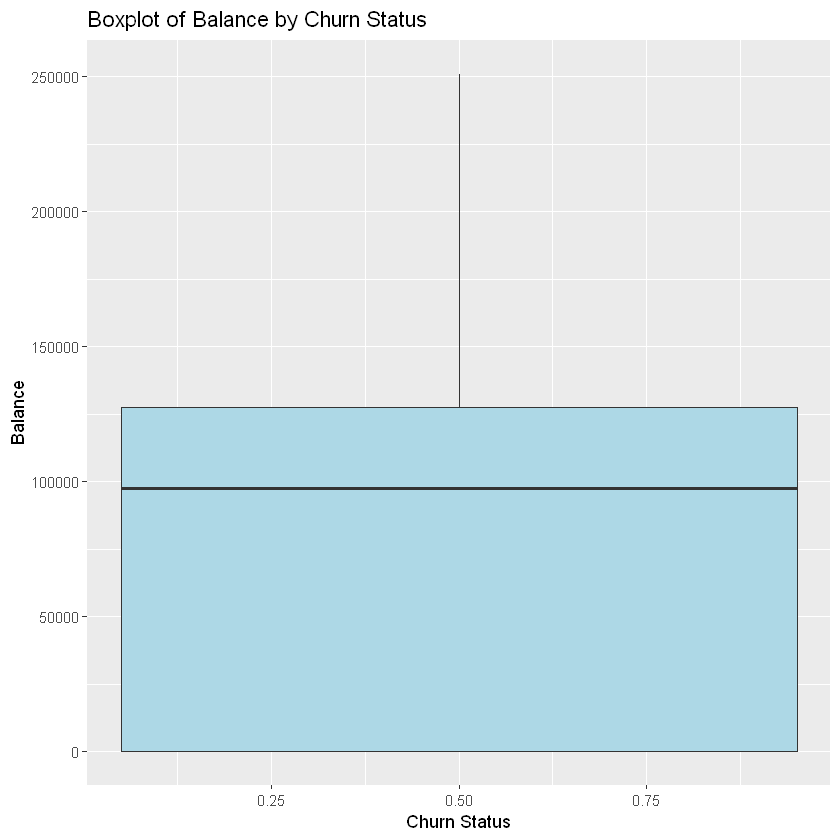

In [40]:
ggplot(data = df, aes(x = churn, y = balance)) +
  geom_boxplot(fill = "lightblue") +
  labs(x = "Churn Status", y = "Balance") +
  ggtitle("Boxplot of Balance by Churn Status")

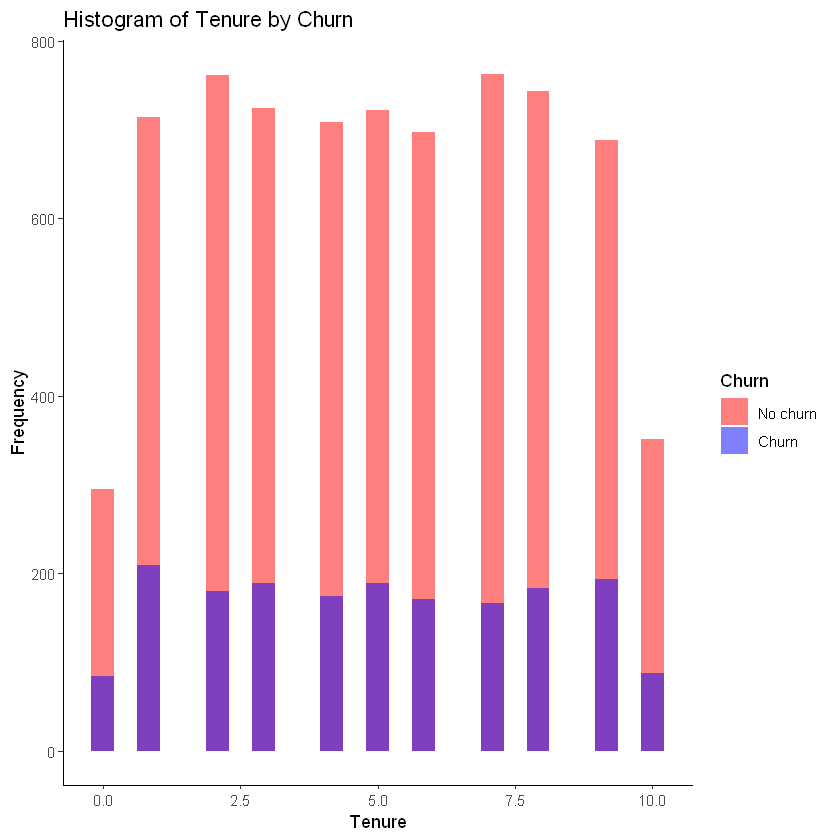

In [41]:
# Plot tenure distribution by churn vs. no-churn
ggplot(df, aes(x = tenure, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Tenure by Churn", x = "Tenure", y = "Frequency", fill = "Churn") +
  theme_classic()

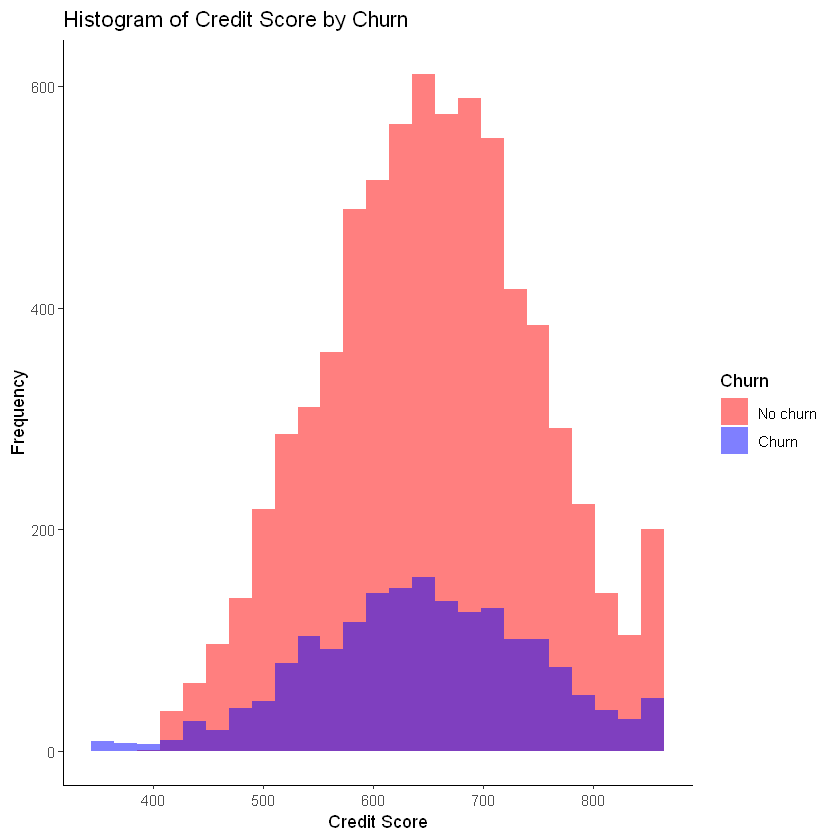

In [42]:
# Plot credit score distribution by churn vs. no-churn
ggplot(df, aes(x = credit_score, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Credit Score by Churn", x = "Credit Score", y = "Frequency", fill = "Churn") +
  theme_classic()

# 3: Model Building

Which variables are the strongest predictors of customer churn? 
How did you conclude that these are the strongest predictors? 
How do different model evaluation metrics (e.g., accuracy, precision, recall) vary for different models? 
Which model would you use for predicting customer churn?

#### 3.1 Logistic regression

In [44]:
# Load and preprocess data
churn_data <- data.frame(new_df)
churn_data$churn <- as.factor(churn_data$churn)
head(churn_data)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,z_creditscore,genderFemale,countryFrance,countryGermany
,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<fct>,"<dbl[,1]>",<dbl>,<dbl>,<dbl>
1,619,42,2,0.00,1,1,1,101348.88,1,-0.3249875,1,1,0
2,608,41,1,83807.86,1,0,1,112542.58,0,-0.4388846,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0.5033549,1,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,2.0668511,1,0,0
5,645,44,8,113755.78,2,1,0,149756.71,1,-0.0557762,0,0,0
6,822,50,7,0.00,2,1,1,10062.80,0,1.7769313,0,1,0


In [60]:
# Create function to normalize numeric features
normalize_data <- function(train, test){
  # Subset the data to only include age, credit_score and estimated_salary
  subset_train <- dplyr::select(train, age, credit_score, estimated_salary)
  subset_test <- dplyr::select(test, age, credit_score, estimated_salary)
  
  # Apply Z-score normalization to both features
  train_norm <- scale(subset_train)
  test_norm <- scale(subset_test)
  
  # Add the normalized features back to the original data frame
  train <- dplyr::mutate(train, 
                          age_norm = train_norm[, "age"], 
                          credit_score_norm = train_norm[, "credit_score"], 
                          estimated_salary_norm = train_norm[, "estimated_salary"], 
                          balance_norm = log(balance + 1))
  test <- dplyr::mutate(test, 
                         age_norm = test_norm[, "age"], 
                         credit_score_norm = test_norm[, "credit_score"], 
                         estimated_salary_norm = test_norm[, "estimated_salary"], 
                         balance_norm = log(balance + 1))
  
  # Return both the normalized train and test data frames
  return(list(train_norm = train, test_norm = test))
}

In [104]:
# Split data into training and testing sets
set.seed(123)
trainIndex <- createDataPartition(churn_data$churn, p = .7, list = FALSE)
train <- churn_data[trainIndex,]
test <- churn_data[-trainIndex,]

# Run normalization function
normalized_data <- normalize_data(train, test)

# view the normalized data
train <- normalized_data$train_norm
test <- normalized_data$test_norm

# Delete non-normlized features
train <- dplyr::select(train, -age, -credit_score, -estimated_salary, -balance, -z_creditscore)
test <- dplyr::select(test, -age, -credit_score, -estimated_salary, -balance, -z_creditscore)

In [105]:
# Fit logistic regression model
logistic_model <- glm(churn ~ ., data = train, family = binomial(link = 'logit'))

# Get summary of model coefficients
summary(logistic_model)


Call:
glm(formula = churn ~ ., family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2608  -0.6600  -0.4567  -0.2698   2.9981  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -1.482058   0.163249  -9.079  < 2e-16 ***
tenure                -0.003667   0.011707  -0.313 0.754112    
products_number       -0.091712   0.060448  -1.517 0.129211    
credit_card           -0.076718   0.074253  -1.033 0.301513    
active_member         -1.056656   0.072479 -14.579  < 2e-16 ***
genderFemale           0.546480   0.068595   7.967 1.63e-15 ***
countryFrance         -0.077864   0.088109  -0.884 0.376843    
countryGermany         0.696547   0.100280   6.946 3.76e-12 ***
age_norm               0.757504   0.033918  22.333  < 2e-16 ***
credit_score_norm     -0.098563   0.034127  -2.888 0.003876 ** 
estimated_salary_norm  0.043934   0.034313   1.280 0.200409    
balance_norm          

The strongest predictors of churn are likely to be credit score, country (Germany), gender (male), age, balance, and active member status, as these have the largest absolute coefficient values and are statistically significant

In [106]:
# Calculate variable importance
var_imp <- varImp(logistic_model)
var_imp

,Overall
,<dbl>
tenure,0.3132223
products_number,1.5172209
credit_card,1.0331938
active_member,14.5787456
genderFemale,7.9667370
countryFrance,0.8837278
countryGermany,6.9460431
age_norm,22.3332888
credit_score_norm,2.8880953


Results without normalization:
+ The most important predictor variable is 'age' with a score of 22.33, indicating that it has the largest impact on predicting the customer churn.
+ The second most important predictor variable is 'active_member' with a score of 14.58, which suggests that the customers who are active members have a higher likelihood of not churning.
+ 'countryGermany' and 'genderFemale' are also strong predictors. This means that customers from Germany are less likely to churn than customers from other countries, and male customers are more likely to churn compared to female customers.
+ 'credit_score', 'balance', 'credit_card', 'products_number', and 'estimated_salary' have smaller importance scores, but they still contribute to the model's predictive power.

In [107]:
# Evaluate model performance on test set
predicted_values <- predict(logistic_model, newdata = test, type = "response")
predicted_classes <- ifelse(predicted_values > 0.5, "Yes", "No")
actual_classes <- test$churn

# Calculate evaluation metrics
confusion_matrix <- table(actual_classes, predicted_classes)
accuracy <- sum(diag(confusion_matrix))/sum(confusion_matrix)
precision <- confusion_matrix[2, 2]/sum(confusion_matrix[, 2])
recall <- confusion_matrix[2, 2]/sum(confusion_matrix[2, ])

# Print evaluation metrics
cat("Accuracy:", accuracy, "\n")
cat("Precision:", precision, "\n")
cat("Recall:", recall, "\n")

Accuracy: 0.8073361 
Precision: 0.6666667 
Recall: 0.1056466 


Results without normalization:
+ The model correctly predicted the outcome for 81.4% of the observations in the test set.
+ Out of all the predicted positive outcomes, only 61.8% of them were actually positive.
+ Out of all the actual positive outcomes, only 22.4% of them were correctly predicted as positive by the model.

#### 3.2 Random forest

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
credit_score,48.21520244,-9.6796177,46.3501530,235.26477
age,73.06585642,94.8617851,107.2012888,492.03236
tenure,-0.21189214,3.5158441,1.7928960,149.78246
balance,29.69885092,29.2455507,45.6016421,276.13735
products_number,81.04610630,78.8024076,96.4680646,279.79482
credit_card,0.01408703,-1.4167334,-0.7324281,37.11585
active_member,40.92815087,23.7327091,46.2166264,78.77620
estimated_salary,1.83723787,-0.9862448,0.9920065,268.36424
z_creditscore,47.58298381,-9.3393387,46.1015117,236.17108
genderFemale,6.38042115,5.8092943,8.4560182,40.75217


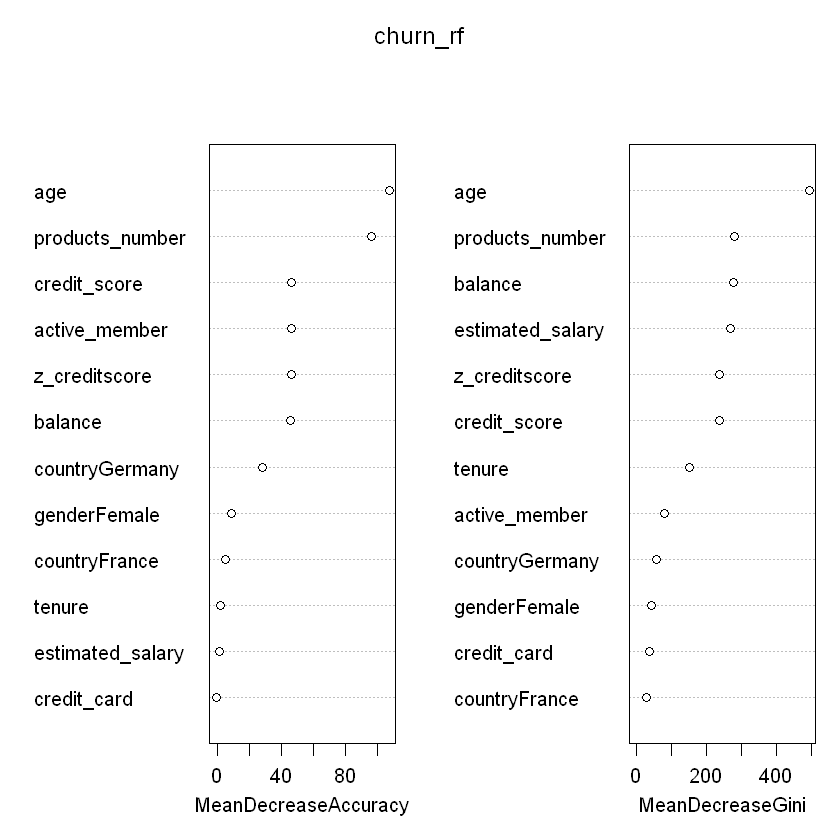

In [94]:
# Load data
churn_data <- data.frame(new_df)
churn_data$churn <- as.factor(churn_data$churn)

# Split data into training and testing sets
set.seed(123)
trainIndex <- createDataPartition(churn_data$churn, p = .8, list = FALSE)
train <- churn_data[trainIndex,]
test <- churn_data[-trainIndex,]

# Fit the random forest model
churn_rf <- randomForest(churn ~ ., data = train, importance = TRUE)

# Identify the strongest predictors of churn
varImpPlot(churn_rf)  # plot variable importance
importance(churn_rf) # return variable importance

In [95]:
# Evaluate the model performance
predicted_churn <- predict(churn_rf, newdata = test)
cm <- confusionMatrix(predicted_churn, test$churn)  # calculate confusion matrix
# Print evaluation metrics
cat("Accuracy:", cm$overall['Accuracy'], "\n")
cat("Precision:", cm$byClass['Precision'], "\n")
cat("Recall:", cm$byClass['Recall'], "\n")

Accuracy: 0.8754864 
Precision: 0.8872518 
Recall: 0.9665038 


+ 88% of the predictions by the model are correct.
+ 89% of the predicted positive cases are actually positive.
+ 97% of the actual positive cases are correctly predicted as positive.

In [67]:
# Higher the value of mean decrease accuracy or mean decrease gini score , higher the importance of the variable in the model.
# Prediction and calculating performance metrics
pred1=predict(churn_rf, type="prob")
perf = prediction(pred1[,2], churn_data$churn)

#area under curve
auc = performance(perf,"auc")
pred3 = performance(perf,"tpr","fpr")
plot(pred3, main="ROC Curve for Random Forest",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=2,col="gray")

ERROR: Error in prediction(pred1[, 2], churn_data$churn): Number of predictions in each run must be equal to the number of labels for each run.


#### 3.3 Support vector machines

In [96]:
# Load the data
churn_data <- data.frame(new_df)
churn_data$churn <- as.factor(churn_data$churn)

# Split data into training and testing sets
set.seed(123)
trainIndex <- createDataPartition(churn_data$churn, p = .8, list = FALSE)
train <- churn_data[trainIndex,]
test <- churn_data[-trainIndex,]

# Run normalization function
normalized_data <- normalize_data(train, test)

# view the normalized data
train <- normalized_data$train_norm
test <- normalized_data$test_norm

# Delete non-normlized features
train <- dplyr::select(train, -age, -credit_score, -estimated_salary, -balance, -z_creditscore)
test <- dplyr::select(test, -age, -credit_score, -estimated_salary, -balance, -z_creditscore)

In [97]:
# Fit the SVM model
svm_model <- svm(churn ~ ., data = train)

# Print the model summary
summary(svm_model)

# Evaluate model performance on test set
predicted_classes <- predict(svm_model, newdata = test)
actual_classes <- test$churn

# Calculate evaluation metrics
confusion_matrix <- confusionMatrix(predicted_classes, actual_classes)
accuracy <- confusion_matrix$overall['Accuracy']
precision <- confusion_matrix$byClass['Pos Pred Value']
recall <- confusion_matrix$byClass['Sensitivity']


Call:
svm(formula = churn ~ ., data = train)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  2699

 ( 1456 1243 )


Number of Classes:  2 

Levels: 
 0 1




In [98]:
# Calculate variable importance
var_imp <- t(svm_model$coefs) %*% svm_model$SV
#var_imp <- data.frame(variable = colnames(train)[-ncol(train)], importance = var_imp)
var <- data.frame(var_imp[1,])
var_imp_t <- t(var_imp)
var_imp_t

tenure,4.2904145
products_number,-19.7361683
credit_card,-0.2831897
active_member,39.5406366
genderFemale,-5.4672937
countryFrance,5.2897318
countryGermany,-12.1018213
age_norm,-8.6675563
credit_score_norm,11.7699379
estimated_salary_norm,-6.7649170
balance_norm,-5.8941019


+ The most important predictors of customer churn are age, balance, and products_number.
+ Active_member is the variable with the most negative impact on churn prediction, which means that active members are less likely to churn.
+ Credit_score and tenure have a relatively low impact on churn prediction compared to other variables.
+ Among the categorical variables, countryGermany has the highest positive impact on churn prediction, followed by genderFemale, and countryFrance has a negative impact on churn prediction.

In [99]:
# Print evaluation metrics
cat("Accuracy:", accuracy, "\n")
cat("Precision:", precision, "\n")
cat("Recall:", recall, "\n")

Accuracy: 0.868816 
Precision: 0.8728972 
Recall: 0.9776692 


Results without normalization:
+ 85% of the predictions by the model are correct.
+ 85.7% of the predicted positive cases are actually positive.
+ 96.95% of the actual positive cases are correctly predicted as positive.

#### 3.4 Gradient boosting

In [ ]:
xgb_model <- xgboost(data = data.matrix(subset(train, select = -churn)),
                     label = train$churn,
                     nrounds = 500,
                     objective = "binary:logistic",
                     max_depth = 6,
                     eta = 0.1,
                     gamma = 0.1,
                     subsample = 0.8,
                     colsample_bytree = 0.8,
                     min_child_weight = 1,
                     verbose = 0)
xgb_model <- xgboost(data = data.matrix(subset(train, select = -churn)),
                     label = train$churn,
                     nrounds = 100,
                     objective = "binary:logistic",
                     verbose = 0)

In [118]:
# Load and prepare the data
churn_data <- data.frame(new_df)

# Split data into training and testing sets
set.seed(123)
trainIndex <- createDataPartition(churn_data$churn, p = 0.8, list = FALSE)
train <- churn_data[trainIndex, ]
test <- churn_data[-trainIndex, ]

# Train XGBoost model
xgb_model <- xgboost(data = data.matrix(subset(train, select = -churn)),
                     label = train$churn,
                     nrounds = 1000,
                     objective = "binary:logistic",
                     max_depth = 6,
                     eta = 0.1,
                     gamma = 0.1,
                     subsample = 0.8,
                     colsample_bytree = 0.8,
                     min_child_weight = 1,
                     verbose = 0)

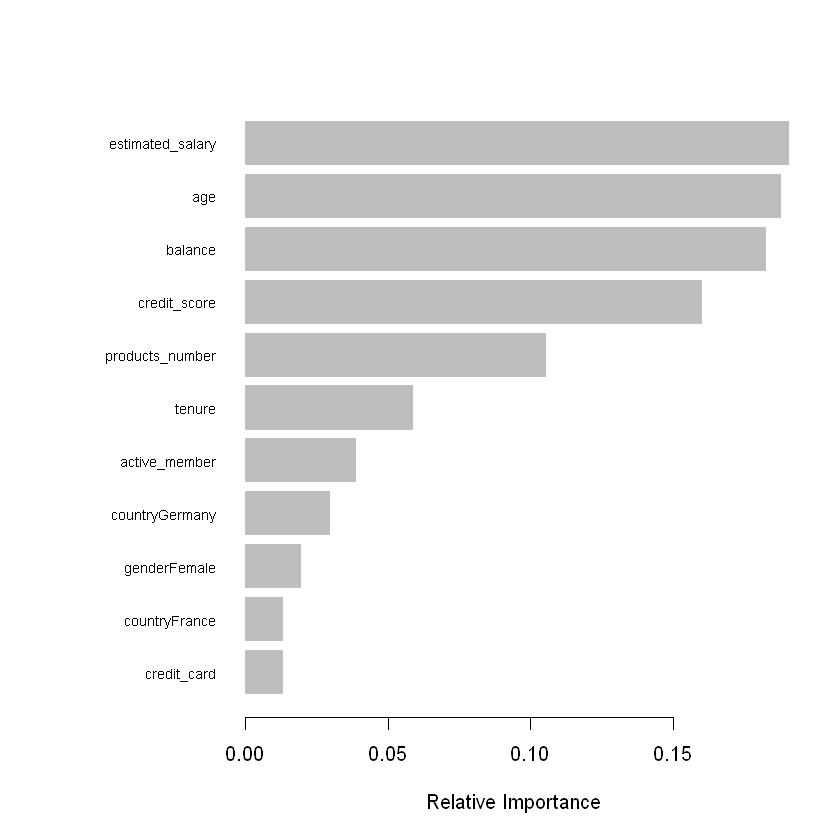

In [116]:
# Variable importance plot
importance_matrix <- xgb.importance(colnames(subset(train, select = -churn)), model = xgb_model)
xgb.plot.importance(importance_matrix, xlab = "Relative Importance")

+ Age, balance and products_number are the three most important predictors

In [119]:
# you've to do your prediction here
pred <- predict(xgb_model, as.matrix(as.matrix(test[,c(-9)])))

# and transform them in a 0 1 variable, you can choose the value to get 1
pred <-  as.numeric(pred > 0.5)

# Save confusion matrix
cm <- confusionMatrix(factor(pred),factor(churn_data[-trainIndex, ]$churn))

# Print evaluation metrics
cat("Accuracy:", cm$overall['Accuracy'], "\n")
cat("Precision:", cm$byClass['Precision'], "\n")
cat("Recall:", cm$byClass['Recall'], "\n")

Accuracy: 0.8333333 
Precision: 0.8682322 
Recall: 0.9314206 


+ The model has correctly predicted 84% of the outcomes.
+ Out of all the positive predictions made by the model, around 87% of them were correct.
+ Out of all the actual positive cases, the model was able to correctly identify around 94% of them.

In [140]:
grid_search(params = list(nrounds = c(100, 200, 400, 800)))

[1]	train-logloss:0.541226 
[2]	train-logloss:0.457338 
[3]	train-logloss:0.406217 
[4]	train-logloss:0.373498 
[5]	train-logloss:0.348700 
[6]	train-logloss:0.330891 
[7]	train-logloss:0.318331 
[8]	train-logloss:0.308562 
[9]	train-logloss:0.300556 
[10]	train-logloss:0.294299 
[11]	train-logloss:0.288000 
[12]	train-logloss:0.282575 
[13]	train-logloss:0.279158 
[14]	train-logloss:0.275101 
[15]	train-logloss:0.272470 
[16]	train-logloss:0.270007 
[17]	train-logloss:0.267113 
[18]	train-logloss:0.263944 
[19]	train-logloss:0.259991 
[20]	train-logloss:0.256610 
[21]	train-logloss:0.254848 
[22]	train-logloss:0.251944 
[23]	train-logloss:0.248309 
[24]	train-logloss:0.247471 
[25]	train-logloss:0.246422 
[26]	train-logloss:0.244825 
[27]	train-logloss:0.239628 
[28]	train-logloss:0.236136 
[29]	train-logloss:0.233688 
[30]	train-logloss:0.231379 
[31]	train-logloss:0.228942 
[32]	train-logloss:0.228194 
[33]	train-logloss:0.225981 
[34]	train-logloss:0.221916 
[35]	train-logloss:0.21

ERROR: Error in x[0, , drop = FALSE]: incorrect number of dimensions


In [129]:
# Define the search grid
grid <- expand.grid(nrounds = c(50, 100, 150, 250),
                    max_depth = c(3, 6, 9),
                    eta = c(0.01, 0.05, 0.1),
                    gamma = c(0, 0.1, 0.5),
                    colsample_bytree = c(0.5, 0.75, 1),
                    min_child_weight = c(1, 5, 10),
                    subsample = c(0.5, 0.75, 1),
                    lambda = c(0.1, 1, 10))

# Train and tune the XGBoost model
set.seed(123)
xgb_model <- train(churn ~ ., data = train, method = "xgbTree",
                   trControl = trainControl(method = "cv", number = 5, verboseIter = TRUE,
                                            classProbs = TRUE, summaryFunction = twoClassSummary),
                   tuneGrid = grid,
                   objective = "binary:logistic")

# Print the results
print(xgb_model)

Warning message in train.default(x, y, weights = w, ...):
"You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column."
Warning message in train.default(x, y, weights = w, ...):
"cannnot compute class probabilities for regression"


ERROR: Error: The tuning parameter grid should have columns nrounds, max_depth, eta, gamma, colsample_bytree, min_child_weight, subsample


#### 3.5 Lightgbm

In [94]:
# Load and prepare the data
churn_data <- data.frame(new_df)

# Split data into training and testing sets
set.seed(123)
trainIndex <- createDataPartition(churn_data$churn, p = 0.8, list = FALSE)
train <- churn_data[trainIndex, ]
test <- churn_data[-trainIndex, ]

X_train <- as.matrix(subset(train, select = -churn))
X_test <- as.matrix(subset(test, select = -churn))
y_train <- as.matrix(train$churn)
y_test <- as.matrix(test$churn)

dtrain = lgb.Dataset(X_train, label = y_train)
dtest = lgb.Dataset.create.valid(dtrain, data = X_test, label = y_test)

# validataion data
valids = list(test = dtest)

In [109]:
params = list(
  objective= 'multiclass',
  metric = "multi_error",
  num_class= 3,
  learning_rate = 0.1,
  max_depth = 5,
  min_data_in_leaf = 50,
  bagging_fraction = 0.8,
  feature_fraction = 0.8
) 


model = lgb.train(params,
                  dtrain,
                  nrounds = 1000,
                  valids,
                  min_data=1,
                  learning_rate = 1,
                  early_stopping_rounds = 100)

Warning message in lgb.train(params, dtrain, nrounds = 1000, valids, min_data = 1, :
"lgb.train: Found the following passed through '...': min_data, learning_rate. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.train for documentation on how to call this function."


[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_data=1 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_data=1 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_data=1 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Accuracy may be bad since you didn't e

In [110]:
# prediction
pred = predict(model, X_test, reshape=T)
pred_y = max.col(pred)-1

In [111]:
# assuming `y_test` and `pred_y` are defined as in your previous question
confusionMatrix(as.factor(y_test), as.factor(pred_y))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1394   35
         1  220  151
                                          
               Accuracy : 0.8583          
                 95% CI : (0.8414, 0.8741)
    No Information Rate : 0.8967          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.4691          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.8637          
            Specificity : 0.8118          
         Pos Pred Value : 0.9755          
         Neg Pred Value : 0.4070          
             Prevalence : 0.8967          
         Detection Rate : 0.7744          
   Detection Prevalence : 0.7939          
      Balanced Accuracy : 0.8378          
                                          
       'Positive' Class : 0               
                        

# 4: Recommendations

Based on your analysis, develop 3 recommendations that will help EBI to better manage customer churn. Explain the rationale behind those 3 recommendations. 

EBI has formulated a list of a subset of its current customers (see the dataset “ebi_exp_customers.csv” to answer this question) and would like to use your prediction model to take proactive measures to retain these customers. Specifically, the bank would target the customers (say, via telemarketing) who have high likelihood of churn.

Use your prediction model to predict the likelihood of churn for each customer in the dataset.

Suppose that the value of retaining a customer is €5 while the cost incurred by the bank to avoid a customer from churning is €1. How many and which customers from the dataset (“ebi_exp_customers.csv”) would you recommend the bank to target to maximize the total expected profit from this proactive targeting experiment? How would your answer change if the value of retaining a customer goes up to €10? Explain your computation

In [62]:
pre_processing <- function(df) {
  # Drop customer_id column
  df <- select(df, -customer_id)
  
  # One-hot encoding of gender variable
  gender_encoded <- model.matrix(~ gender - 1, data = df)
  new_df <- cbind(df, gender_encoded)
  
  # One-hot encoding of country variable
  country_encoded <- model.matrix(~ country - 1, data = df)
  new_df <- cbind(new_df, country_encoded)
  
  # Drop redundant columns
  new_df <- select(new_df, -gender, -genderMale, -country, -countrySpain)
  
  return(new_df)
}

In [63]:
df_2 <- read.csv("ebi_exp_customers.csv")
df_2 <- pre_processing(df_2)
head(df_2)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,genderFemale,countryFrance,countryGermany
,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,579,33,1,118392.8,1,1,1,157564.75,0,1,1,0
2,728,59,4,0.0,1,1,1,163365.85,1,1,1,0
3,660,40,5,131754.1,2,1,1,38761.61,0,0,1,0
4,543,37,3,122304.6,2,0,0,33998.70,0,1,0,1
5,572,43,2,140432.0,1,1,0,26450.57,1,0,1,0
6,694,31,6,109052.6,2,1,1,19448.93,1,0,0,1


In [70]:
# Load data
churn_data <- data.frame(new_df)
churn_data$churn <- as.factor(churn_data$churn)
df_2$churn <- as.factor(df_2$churn)

# Fit the random forest model
churn_rf <- randomForest(churn ~ ., data = churn_data, importance = TRUE, ntree = 500)

In [71]:
# Define function to answer question of how many and which customers to target in EUR 5 and EUR 10 scenario
customer_retention <- function(df) {
    
    # Set the cost and value of retention
    retention_cost <- 1
    retention_value_5 <- 5
    retention_value_10 <- 10
    
    # Calculate churn probability for every customer in data set
    df$churn_probs <- predict(churn_rf, newdata = df, type = "prob")[,2]
    
    # Sort data set based on churn probability per customer
    df <- df %>% arrange(desc(churn_probs))
    
    # Caculate expected profit per customer
    df$cost <- 1
    df$expected_profit_5 <- retention_value_5 * df$churn_probs - df$cost
    df$expected_profit_10 <- retention_value_10 * df$churn_probs - df$cost
    
    # Calculate the number of customers to be targeted in EUR 5 and EUR 10 scenario and print them
    num_cust_5 <- sum(df$expected_profit_5 > 0)
    num_cust_10 <- sum(df$expected_profit_10 > 0)
    print(paste0("Out of a total of 1,000 customers, ",  num_cust_5, " are to be targeted in the EUR 5 value scenario value and ", num_cust_10, " in the EUR 10 value scenario."))    
    
    # Calculate total expected profit per scenario
    tot_profit_5 <- sum(df$expected_profit_5[df$expected_profit_5 > 0])
    tot_profit_10 <- sum(df$expected_profit_10[df$expected_profit_10 > 0])
    print(paste0("The total expected profit in the EUR 5 scenario would be ",  tot_profit_5, " and ", tot_profit_10, " in the EUR 10 scenario."))    
    
    # Save two separate data sets with the customers to be targeted in the two scenarios
    df_5_scenario <- df %>% filter(expected_profit_5 > 0)
    df_10_scenario <- df %>% filter(expected_profit_10 > 0)
    
    return(list(df_5_scenario, df_10_scenario, num_cust_5, num_cust_10, tot_profit_5, tot_profit_10))
}

In [72]:
results <- customer_retention(df_2)

# Save output of customer retention function
df_5_scenario <- results[[1]]
df_10_scenario <- results[[2]]
num_cust_5 <- results[[3]]
num_cust_10 <- results[[4]]
tot_profit_5 <- results[[5]]
tot_profit_10 <- results[[6]]

[1] "Out of a total of 1,000 customers, 325 are to be targeted in the EUR 5 value scenario value and 496 in the EUR 10 value scenario."
[1] "The total expected profit in the EUR 5 scenario would be 442.14 and 1290.82 in the EUR 10 scenario."


[1] "Out of a total of 1,000 customers, 312 are to be targeted in the EUR 5 value scenario value and 503 in the EUR 10 value scenario."
[1] "The total expected profit in the EUR 5 scenario would be 447.61 and 1295.62 in the EUR 10 scenario."

In [73]:
# Create column to identify scenarios
df_5_scenario$scenario <- 0
df_10_scenario$scenario <- 1

# combine both data frames into one
df_vis <- rbind(df_5_scenario, df_10_scenario)

In [74]:
# Define a function that takes a dataframe and a list of numeric variables as input to create historgrams and return mean values
plot_var_by_scenario <- function(df, vars) {
  
  for(var in vars) {
    
    # create plot of variable distribution
    p <- ggplot(df, aes(x = !!sym(var), fill = as.factor(scenario))) +
      geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
      scale_fill_manual(values = c("red", "blue"), labels=c('EUR 5 scenario', 'EUR 10 scenario')) +
      labs(title = paste0("Histogram of ", var, " in EUR 5 vs EUR 10 scenario"), 
           x = var, y = "Frequency", fill = "Scenario") +
      theme_classic()
    
    # print plot
    print(p)
    
    # calculate and print mean and median values by scenario
    mean_5 <- mean(df[[var]][df$scenario == 0], na.rm = TRUE)
    mean_10 <- mean(df[[var]][df$scenario == 1], na.rm = TRUE)
    cat(paste0("Mean ", var, " in EUR 5 scenario: ", round(mean_5, 2), "; Median: ", median(df[[var]][df$scenario == 0]),"\n"))
    cat(paste0("Mean ", var, " in EUR 10 scenario: ", round(mean_10, 2), "; Median: ", median(df[[var]][df$scenario == 1]),"\n\n"))
  }
}

In [77]:
# Test whether there are statistical differences between customers to be targeted in EUR 5 and EUR 10 scenario
numeric_vars <- c("credit_score", "age", "tenure", "balance", "estimated_salary", "churn_probs", "products_number")
categorical_vars <- c("credit_card", "active_member","genderFemale","countryFrance", "countryGermany")
statistical_test_results <- test_variables(df_vis, numeric_vars = numeric_vars, categorical_vars = categorical_vars, "scenario")

[1] "age has a statistically significant relationship with scenario: p = 0.000261324117486729"
[1] "churn_probs has a statistically significant relationship with scenario: p = 2.21759590600362e-10"


[1] "age has a statistically significant relationship with scenario: p = 6.93390935114435e-05"
[1] "churn_probs has a statistically significant relationship with scenario: p = 7.81869440851485e-13"

Mean credit_score in EUR 5 scenario: 647.65; Median: 650
Mean credit_score in EUR 10 scenario: 652.84; Median: 661.5



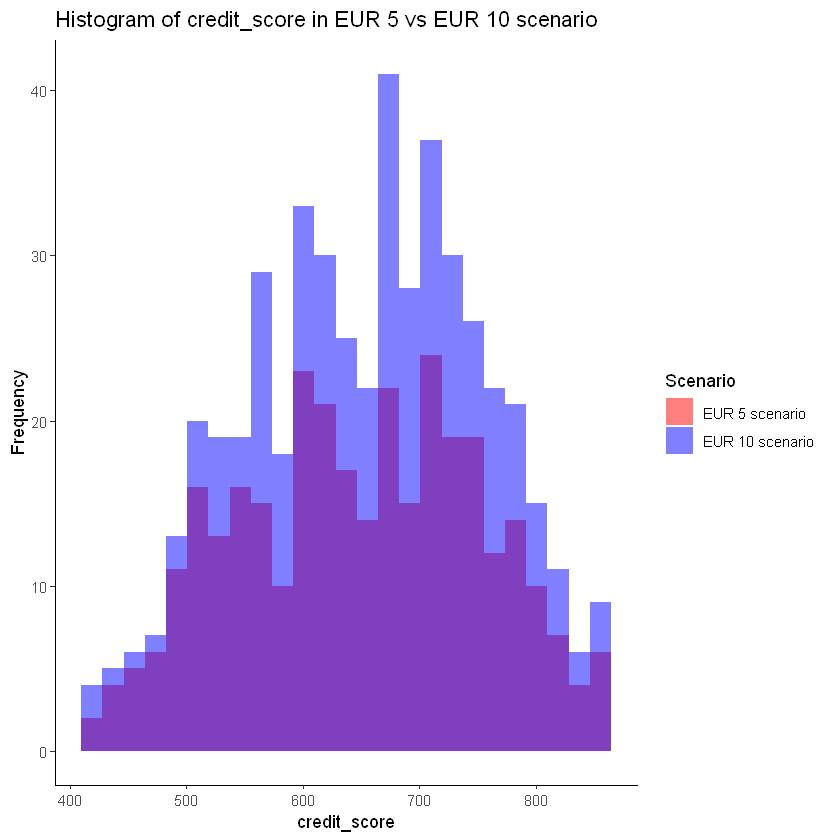

Mean age in EUR 5 scenario: 45.86; Median: 45
Mean age in EUR 10 scenario: 43.19; Median: 42



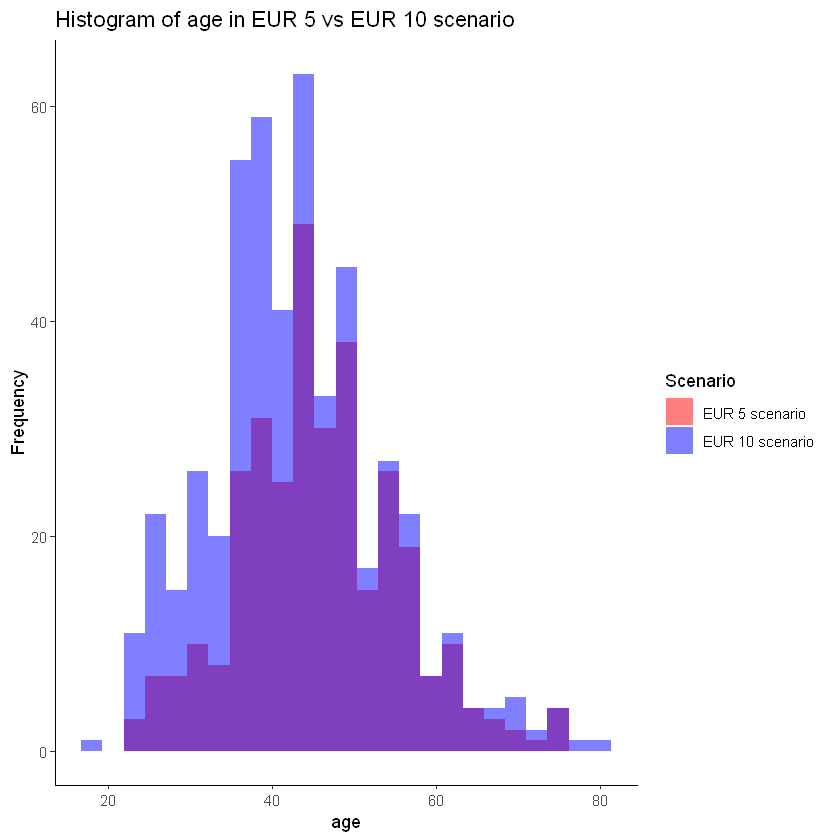

Mean balance in EUR 5 scenario: 91128.03; Median: 106804.26
Mean balance in EUR 10 scenario: 92245.14; Median: 106516.29



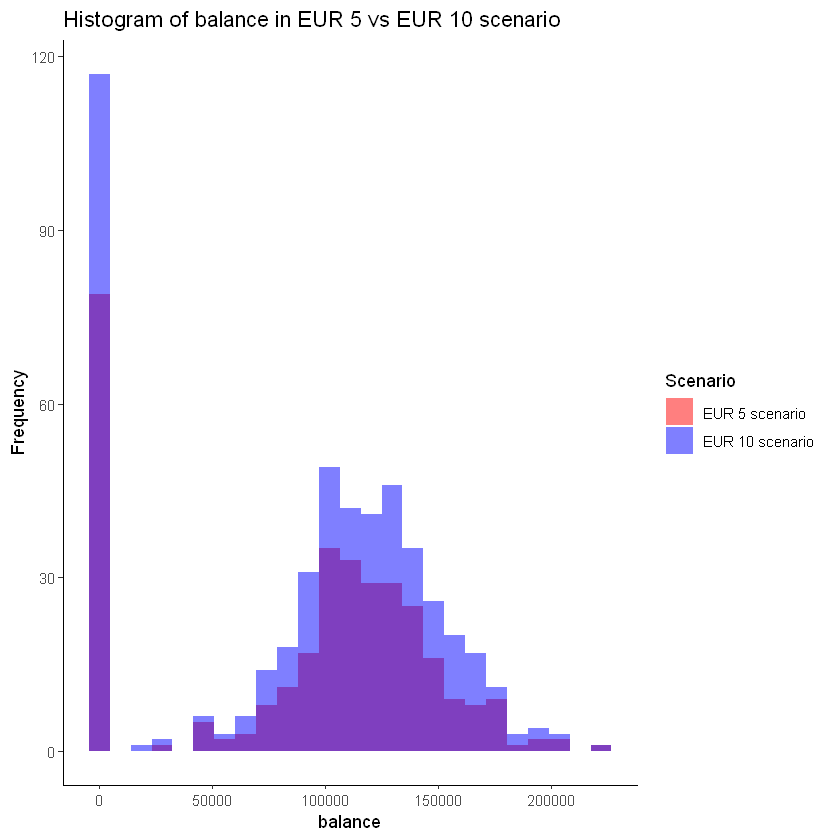

Mean products_number in EUR 5 scenario: 1.42; Median: 1
Mean products_number in EUR 10 scenario: 1.39; Median: 1



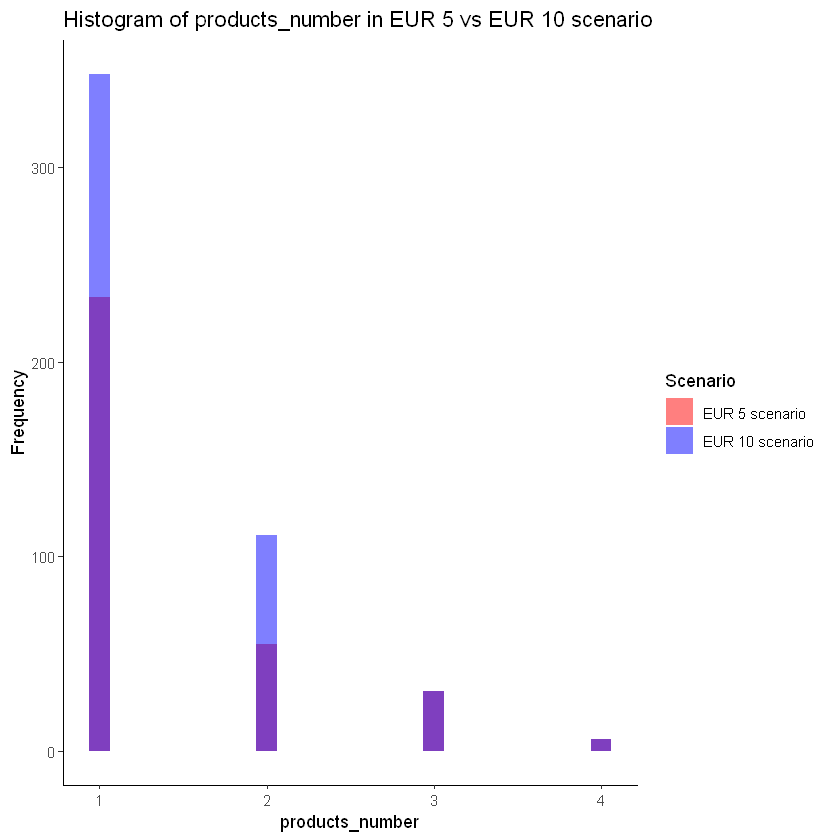

Mean estimated_salary in EUR 5 scenario: 97434.93; Median: 99922.08
Mean estimated_salary in EUR 10 scenario: 98206.45; Median: 100897.48



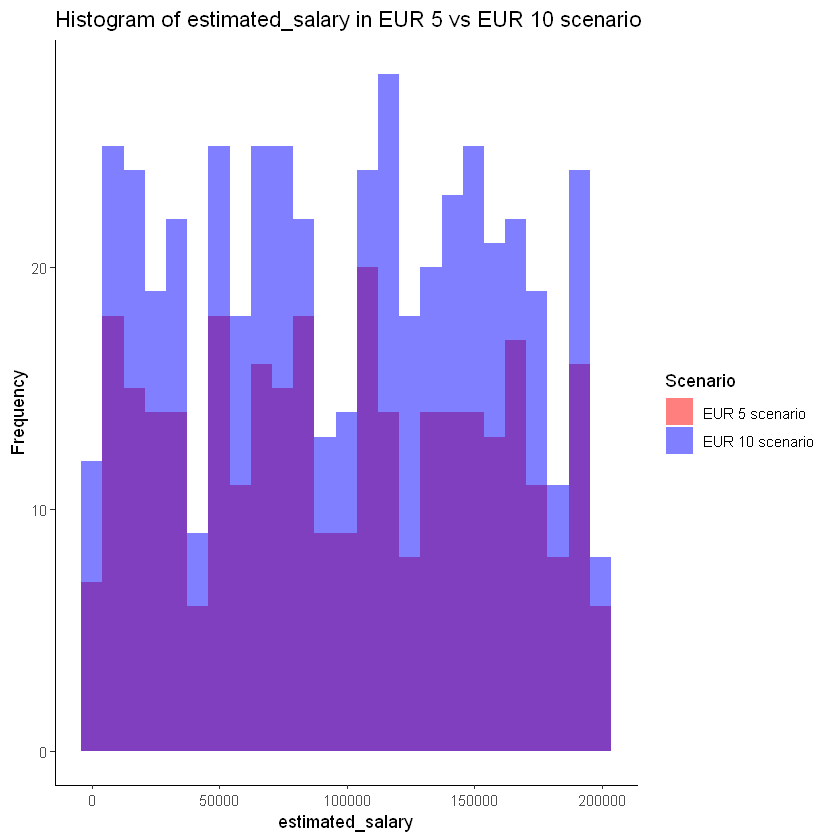

Mean churn_probs in EUR 5 scenario: 0.47; Median: 0.378
Mean churn_probs in EUR 10 scenario: 0.36; Median: 0.258



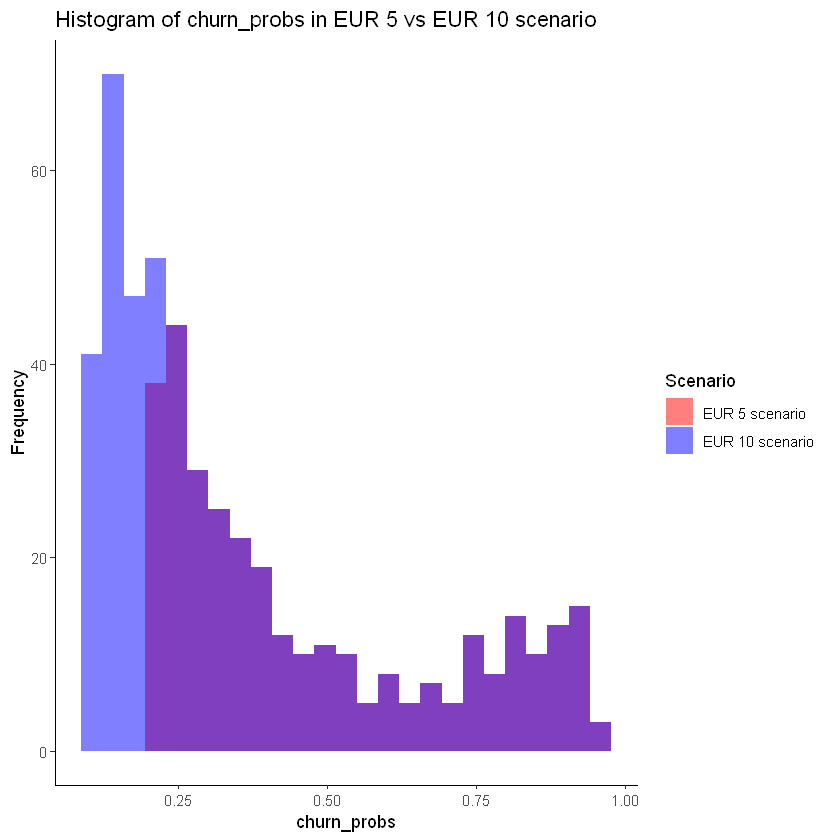

In [78]:
# Define list of variables to plot histograms for
vars <- c("credit_score", "age", "balance","products_number","estimated_salary", "churn_probs")
plot_var_by_scenario(df_vis,vars)

In [80]:
# Define variables for cluster analysis
cluster_vars <- c("age", "balance", "products_number", "estimated_salary", "credit_score", "active_member")

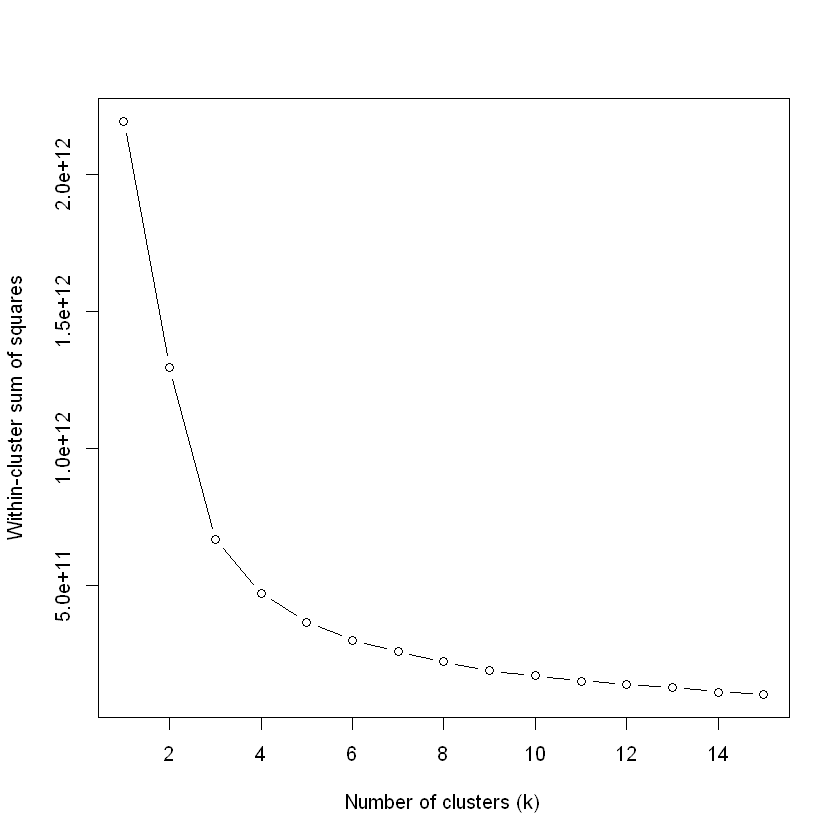

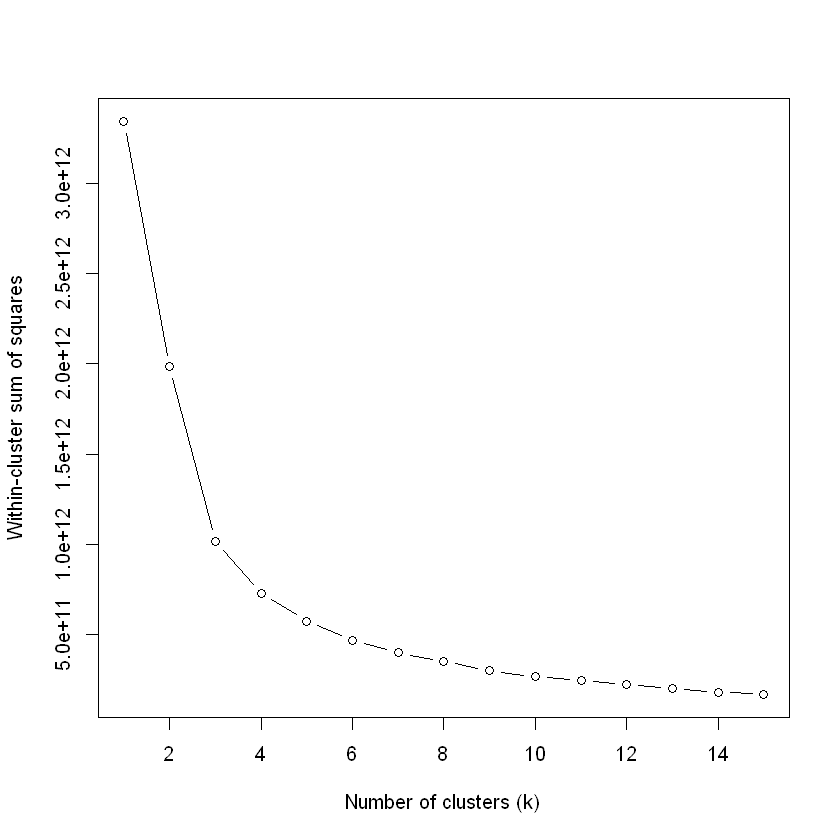

In [83]:
set.seed(123)
wss <- sapply(1:15, function(k) {
  kmeans(df_5_scenario[, cluster_vars], k, nstart = 10)$tot.withinss
})
plot(1:15, wss, type = "b", xlab = "Number of clusters (k)", ylab = "Within-cluster sum of squares")

# Repeat for scenario 2
wss2 <- sapply(1:15, function(k) {
  kmeans(df_10_scenario[, cluster_vars], k, nstart = 10)$tot.withinss
})
plot(1:15, wss2, type = "b", xlab = "Number of clusters (k)", ylab = "Within-cluster sum of squares")

             Length Class  Mode   
cluster      325    -none- numeric
centers       18    -none- numeric
totss          1    -none- numeric
withinss       3    -none- numeric
tot.withinss   1    -none- numeric
betweenss      1    -none- numeric
size           3    -none- numeric
iter           1    -none- numeric
ifault         1    -none- numeric


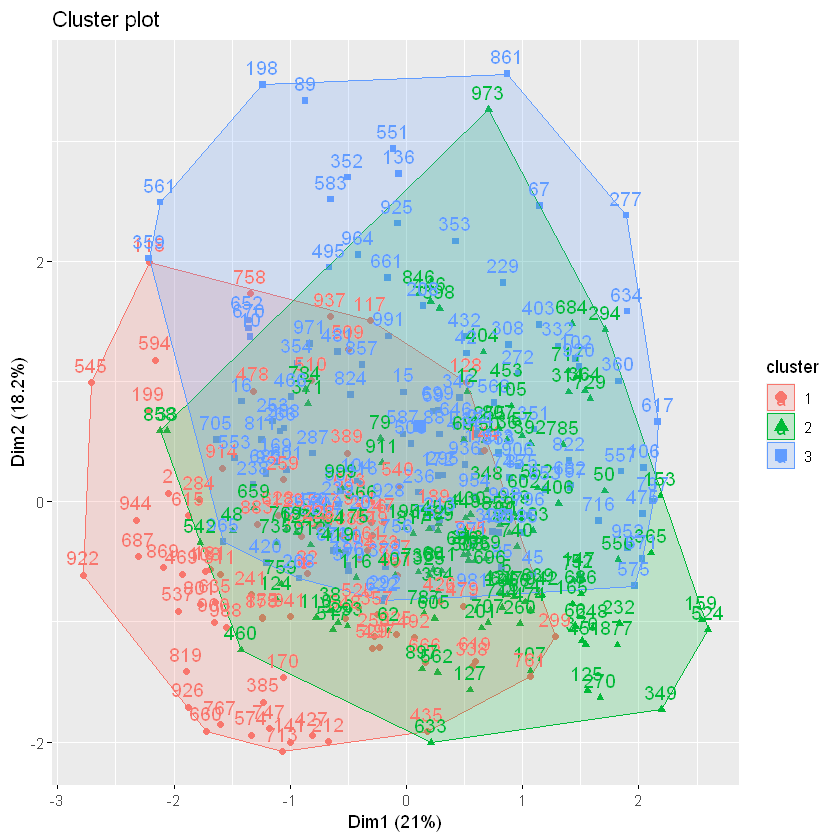

In [91]:
# Perform cluster analysis on scenario 1
cluster_5_scenario <- kmeans(df_5_scenario[, cluster_vars], centers = 3, nstart = 25)

# Print cluster results for scenario 1
print(summary(cluster_5_scenario))

# Plot cluster results for scenario 1
fviz_cluster(cluster_5_scenario, data = df_5_scenario[, cluster_vars])

             Length Class  Mode   
cluster      496    -none- numeric
centers       18    -none- numeric
totss          1    -none- numeric
withinss       3    -none- numeric
tot.withinss   1    -none- numeric
betweenss      1    -none- numeric
size           3    -none- numeric
iter           1    -none- numeric
ifault         1    -none- numeric


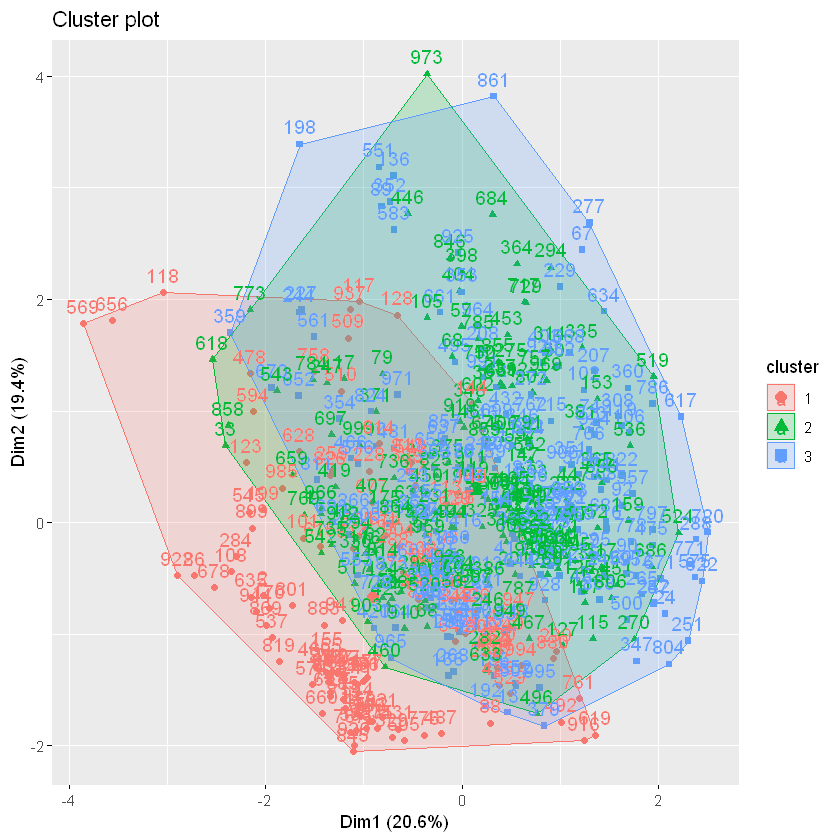

In [93]:
# Perform cluster analysis on scenario 2
cluster_10_scenario <- kmeans(df_10_scenario[, cluster_vars], centers = 3, nstart = 25)

# Print cluster results for scenario 2
print(summary(cluster_10_scenario))

# Plot cluster results for scenario 2
fviz_cluster(cluster_10_scenario, data = df_10_scenario[, cluster_vars])

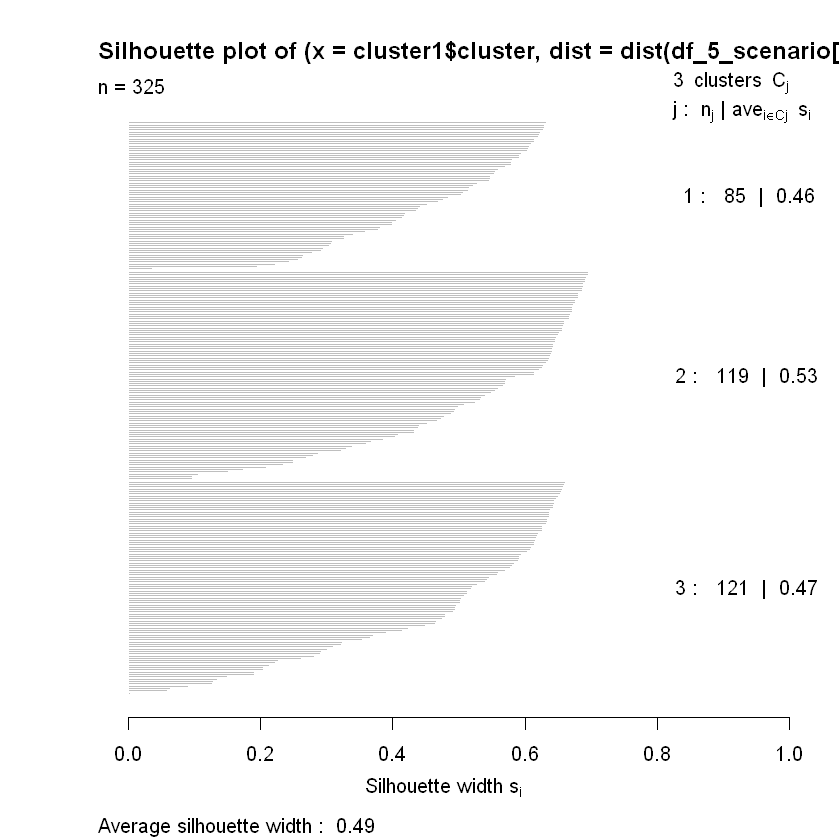

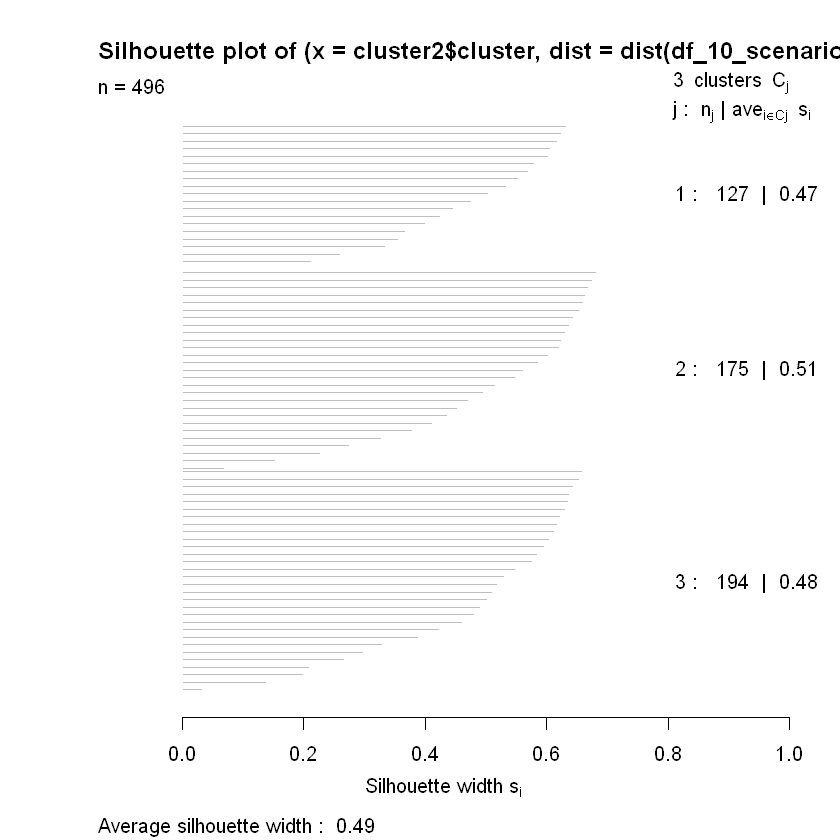

In [94]:
sil_width <- silhouette(cluster_5_scenario$cluster, dist(df_5_scenario[, cluster_vars]))
plot(sil_width)

# Plot silhouette plot for scenario 2
sil_width2 <- silhouette(cluster_10_scenario$cluster, dist(df_10_scenario[, cluster_vars]))
plot(sil_width2)

In [97]:
print_cluster_means <- function(cluster, data, vars) {
  
  # Add cluster assignment to data
  data$cluster <- factor(cluster$cluster)
  
  # Calculate mean and median values for each variable and cluster
  for (var in vars) {
    cat(paste0("Mean ", var, ":\n"))
    print(tapply(data[[var]], data$cluster, mean))
    cat(paste0("\nMedian ", var, ":\n"))
    print(tapply(data[[var]], data$cluster, median))
    cat("\n")
  }
}

In [98]:
cluster_vis_vars <- c("balance", "estimated_salary", "active_member")
print_cluster_means(cluster_10_scenario, df_10_scenario, cluster_vars)

Mean age:
       1        2        3 
44.00000 42.81714 43.00000 

Median age:
 1  2  3 
43 42 42 

Mean balance:
         1          2          3 
  3360.483 120809.058 124666.106 

Median balance:
       1        2        3 
     0.0 117294.1 123577.3 

Mean products_number:
       1        2        3 
1.322835 1.360000 1.448454 

Median products_number:
1 2 3 
1 1 1 

Mean estimated_salary:
        1         2         3 
 95270.17  45177.06 147964.45 

Median estimated_salary:
        1         2         3 
 93081.87  47166.55 146441.86 

Mean credit_score:
       1        2        3 
648.3465 660.4457 648.9330 

Median credit_score:
    1     2     3 
645.0 670.0 650.5 

Mean active_member:
        1         2         3 
0.5511811 0.3657143 0.4381443 

Median active_member:
1 2 3 
1 0 0 



In [99]:
print_cluster_means(cluster_5_scenario, df_5_scenario, cluster_vars)

Mean age:
       1        2        3 
46.25882 44.35294 47.04959 

Median age:
 1  2  3 
47 45 45 

Mean balance:
         1          2          3 
  3117.775 119999.764 124558.904 

Median balance:
       1        2        3 
     0.0 115371.9 123105.9 

Mean products_number:
       1        2        3 
1.364706 1.361345 1.504132 

Median products_number:
1 2 3 
1 1 1 

Mean estimated_salary:
        1         2         3 
 98677.95  45163.81 147968.87 

Median estimated_salary:
       1        2        3 
100015.8  46864.0 146372.5 

Mean credit_score:
       1        2        3 
643.2824 655.2521 643.2479 

Median credit_score:
  1   2   3 
630 663 640 

Mean active_member:
        1         2         3 
0.4941176 0.2941176 0.3966942 

Median active_member:
1 2 3 
0 0 0 

